[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

获取QQQ数据...
获取SPY数据...
获取标普500指数数据...
获取有色金属etf(159980)数据...


获取恒生科技(513010)数据...
获取恒生医药(159892)数据...
获取黄金etf(159934)数据...
获取豆粕etf(159985)数据...
获取红利ETF(510880)数据...
获取稀土(516780)数据...

季度选择记录:
2021-09-30: 选择基金  (现金)
2021-12-31: 选择基金 510880, 159985, 159934, 159980 (红利ETF, 豆粕etf, 黄金etf, 有色金属etf)
2022-03-31: 选择基金 513010, 516780, QQQ, SPY (恒生科技, 稀土, 纳斯达克ETF, 标普500ETF)
2022-06-30: 选择基金 159980, SPY, 159985, 510880 (有色金属etf, 标普500ETF, 豆粕etf, 红利ETF)
2022-09-30: 选择基金 159892, 516780, SPY, QQQ (恒生医药, 稀土, 标普500ETF, 纳斯达克ETF)
2022-12-31: 选择基金 516780, QQQ, 159934, SPY (稀土, 纳斯达克ETF, 黄金etf, 标普500ETF)
2023-03-31: 选择基金 159892, 159980, 513010, 510880 (恒生医药, 有色金属etf, 恒生科技, 红利ETF)
2023-06-30: 选择基金 513010, 516780, 159980, 510880 (恒生科技, 稀土, 有色金属etf, 红利ETF)
2023-09-30: 选择基金 SPY, QQQ, 513010, 159892 (标普500ETF, 纳斯达克ETF, 恒生科技, 恒生医药)
2023-12-31: 选择基金 159985, 513010, 510880, 159892 (豆粕etf, 恒生科技, 红利ETF, 恒生医药)
2024-03-31: 选择基金 513010, 159985, 516780, 159980 (恒生科技, 豆粕etf, 稀土, 有色金属etf)
2024-06-30: 选择基金 159892, 159985, 513010, 510880 (恒生医药, 豆粕etf, 恒生科技, 红利ETF)
2024-09-30: 选择基金 1599

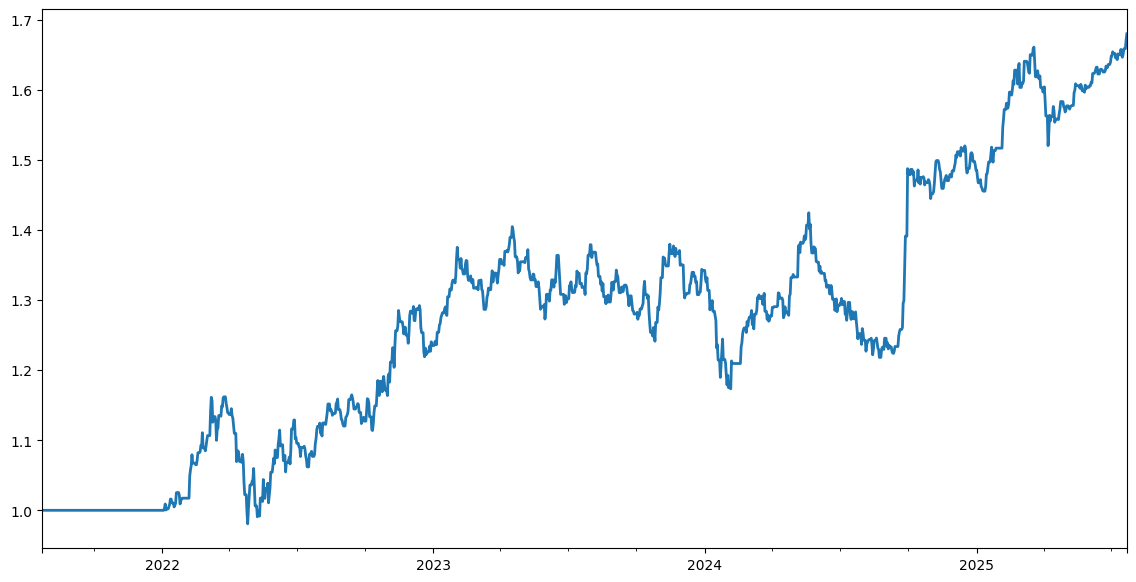

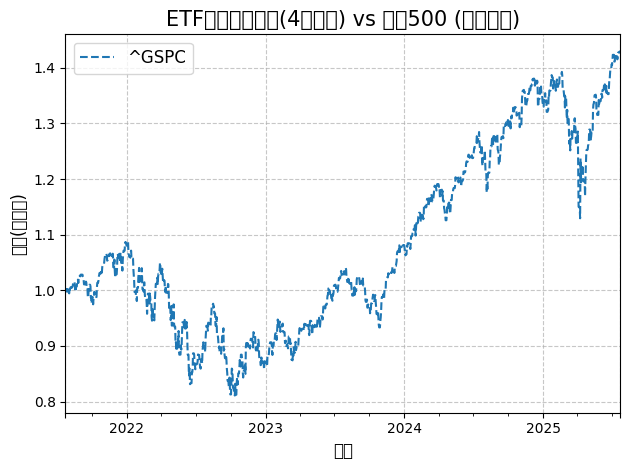

In [82]:
# 导入所需库
import yfinance as yf
import akshare as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 设置回测日期范围
end_date = datetime(2025, 7, 22)
start_date = end_date - timedelta(days=4*365)

# ================== 数据获取部分 ==================

# 获取国际ETF数据 (yfinance) - 加入SPY(标普500ETF)
intl_etfs = {
    'QQQ': '纳斯达克ETF',
    # 'SOYB': '大豆ETF',
    # 'GLD': '黄金ETF',
    # "BTC-USD":"Bitcoin",
    # 'SHY': 'usbond-ETF',
    'SPY': '标普500ETF'  # 新增SPY
}

intl_data = {}
for ticker, name in intl_etfs.items():
    print(f"获取{ticker}数据...")
    df = yf.download(ticker, start=start_date, end=end_date)
    if not df.empty:
        intl_data[ticker] = df[['Close']].rename(columns={'Close': 'close'})

# 获取标普500数据作为基准
print("获取标普500指数数据...")
sp500 = yf.download('^GSPC', start=start_date, end=end_date)[['Close']].rename(columns={'Close': 'close'})

# 获取中国ETF数据 (AKShare)
def fetch_etf_data_ak(symbol, start_date, end_date):
    """通过AKShare获取ETF数据"""
    try:
        df = ak.fund_etf_hist_em(symbol=symbol, period="daily", 
                                start_date=start_date.strftime("%Y%m%d"), 
                                end_date=end_date.strftime("%Y%m%d"), 
                                adjust="hfq")
        df = df.rename(columns={'日期':'date', '收盘':'close'})
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        return df[['close']]
    except Exception as e:
        print(f"获取{symbol}数据失败: {e}")
        return None

# 中国ETF列表
china_etfs = {
    # '159806': '新能源车etf',
    # '513030': '德国etf',
    '159980': '有色金属etf',
    '513010': '恒生科技',
    # '159740': '恒生科技2',
    # '513520': '日本etf',
    # '159819':'人工智能etf',
    '159892': '恒生医药',
    '159934': '黄金etf',
    '159985': '豆粕etf',
    '510880': '红利ETF',
    # '513120': '创新药',
    '516780': '稀土',
    # '588080': '科创50',
    # '511010': '上证5年期国债ETF'
}

china_data = {}
for code, name in china_etfs.items():
    print(f"获取{name}({code})数据...")
    df = fetch_etf_data_ak(code, start_date, end_date)
    if df is not None and not df.empty:
        china_data[code] = df

# 合并所有ETF数据
all_etfs = {}
for ticker, df in intl_data.items():
    all_etfs[ticker] = df
    
for code, df in china_data.items():
    all_etfs[code] = df

# 确保所有数据都有相同的日期索引
all_dates = pd.date_range(start_date, end_date)
for ticker in all_etfs:
    all_etfs[ticker] = all_etfs[ticker].reindex(all_dates).fillna(method='ffill')

# 标准化标普500数据
sp500 = sp500.reindex(all_dates).fillna(method='ffill')

# ================== 策略回测部分 ==================

def quarterly_rotation_backtest(etf_data, start_date, end_date, initial_capital=100000):
    """
    季度轮动策略回测（反转策略）
    :param etf_data: 包含所有ETF数据的字典
    :param start_date: 回测开始日期
    :param end_date: 回测结束日期
    :param initial_capital: 初始资金(10万)
    :return: 回测结果DataFrame和季度选择记录
    """
    # 创建季度末日期序列
    # quarters = pd.date_range(start_date, end_date, freq='Q')
    
    # 创建季度末日期序列（确保包含最后一个季度）
    quarters = pd.date_range(start_date, end_date, freq='Q')
    if end_date not in quarters:  # 如果结束日期不是季度末，则添加
        quarters = quarters.append(pd.DatetimeIndex([end_date]))
    
    # 初始化持仓和组合价值
    portfolio_value = pd.Series(index=pd.date_range(start_date, end_date), dtype=float)
    portfolio_value.iloc[0] = initial_capital
    current_holdings = {}  # {ticker: shares}
    current_cash = initial_capital
    
    # 存储季度选择记录
    quarterly_selections = []
    
    # 按季度循环
    for i in range(len(quarters)-1):
        quarter_start = quarters[i]
        quarter_end = quarters[i+1]
        
        # 计算过去一个季度的收益率
        prev_quarter_start = quarter_start - pd.offsets.QuarterEnd()
        returns = {}
        for ticker, df in etf_data.items():
            if prev_quarter_start in df.index and quarter_start in df.index:
                start_price = df.loc[prev_quarter_start, 'close']
                end_price = df.loc[quarter_start, 'close']
                # 确保获取的是标量值而不是Series
                if isinstance(start_price, pd.Series):
                    start_price = start_price.iloc[0]
                if isinstance(end_price, pd.Series):
                    end_price = end_price.iloc[0]
                returns[ticker] = (end_price - start_price) / start_price

        
        # 选择收益率最低的4只ETF（反转策略）
        if len(returns) >= 4:
            # 确保所有返回值都是标量
            valid_returns = {k: v for k, v in returns.items() if not isinstance(v, (pd.Series, pd.DataFrame))}
            selected = sorted(valid_returns.items(), key=lambda x: x[1])[:4]  # 改为升序排序，选择表现最差的
            selected_tickers = [x[0] for x in selected]
            selected_names = [intl_etfs.get(ticker, china_etfs.get(ticker, ticker)) for ticker in selected_tickers]
            quarterly_selections.append((quarter_start, selected_tickers, selected_names))
        else:
            # 如果没有足够数据，保持现金
            selected_tickers = []
            quarterly_selections.append((quarter_start, [], ["现金"]))

        # 选择收益率第2-5名的ETF（跳过表现最差的第一名）
        # if len(returns) >= 5:  # 需要至少5只ETF才能选择第2-5名
        #     # 确保所有返回值都是标量
        #     valid_returns = {k: v for k, v in returns.items() if not isinstance(v, (pd.Series, pd.DataFrame))}
        #     sorted_returns = sorted(valid_returns.items(), key=lambda x: x[1])  # 升序排序，表现最差的在前
            
        #     # 选择第2-5名（跳过第一名）
        #     selected = sorted_returns[1:5]  # 从索引1开始取4个
        #     selected_tickers = [x[0] for x in selected]
        #     selected_names = [intl_etfs.get(ticker, china_etfs.get(ticker, ticker)) for ticker in selected_tickers]
        #     quarterly_selections.append((quarter_start, selected_tickers, selected_names))
        # elif len(returns) >= 4:
        #     # 如果只有4只，则回退到选择前4名（保持原逻辑）
        #     valid_returns = {k: v for k, v in returns.items() if not isinstance(v, (pd.Series, pd.DataFrame))}
        #     selected = sorted(valid_returns.items(), key=lambda x: x[1])[:4]
        #     selected_tickers = [x[0] for x in selected]
        #     selected_names = [intl_etfs.get(ticker, china_etfs.get(ticker, ticker)) for ticker in selected_tickers]
        #     quarterly_selections.append((quarter_start, selected_tickers, selected_names))
        # else:
        #     # 如果没有足够数据，保持现金
        #     selected_tickers = []
        #     quarterly_selections.append((quarter_start, [], ["现金"]))

        # # 选择收益率最低的4只ETF（反转策略），并额外记录第五名
        # if len(returns) >= 4:
        #     # 确保所有返回值都是标量
        #     valid_returns = {k: v for k, v in returns.items() if not isinstance(v, (pd.Series, pd.DataFrame))}
        #     sorted_returns = sorted(valid_returns.items(), key=lambda x: x[1])  # 升序排序，表现最差的在前
            
        #     # 选择前4只作为持仓
        #     selected = sorted_returns[:4]
        #     selected_tickers = [x[0] for x in selected]
        #     selected_names = [intl_etfs.get(ticker, china_etfs.get(ticker, ticker)) for ticker in selected_tickers]
            
        #     # 获取第五名（如果存在）
        #     fifth_info = None
        #     if len(sorted_returns) >= 5:
        #         fifth_ticker = sorted_returns[4][0]
        #         fifth_name = intl_etfs.get(fifth_ticker, china_etfs.get(fifth_ticker, fifth_ticker))
        #         fifth_info = f"第五名: {fifth_ticker}({fifth_name})"
            
        #     # 在记录中添加第五名信息
        #     if fifth_info:
        #         quarterly_selections.append((quarter_start, selected_tickers, selected_names + [fifth_info]))
        #     else:
        #         quarterly_selections.append((quarter_start, selected_tickers, selected_names))
        # else:
        #     # 如果没有足够数据，保持现金
        #     selected_tickers = []
        #     quarterly_selections.append((quarter_start, [], ["现金"]))

        # 计算调仓日价格
        rebalance_prices = {}
        for ticker in selected_tickers:
            price = etf_data[ticker].loc[quarter_start, 'close']
            if isinstance(price, pd.Series):
                price = price.iloc[0]
            rebalance_prices[ticker] = price
        
        # 卖出当前持仓
        for ticker, shares in current_holdings.items():
            if quarter_start in etf_data[ticker].index:
                price = etf_data[ticker].loc[quarter_start, 'close']
                if isinstance(price, pd.Series):
                    price = price.iloc[0]
                current_cash += shares * price
        
        current_holdings = {}
        
        # 买入新持仓(每只基金分配25%资金)
        if selected_tickers:
            allocation = current_cash / len(selected_tickers)  # 4只基金各25%
            for ticker in selected_tickers:
                price = rebalance_prices[ticker]
                shares = allocation / price
                current_holdings[ticker] = shares
                current_cash -= shares * price

        # 买入新持仓(按2:2:3:3比例分配资金)
        # if selected_tickers:
        #     # 确保有4只ETF被选中
        #     if len(selected_tickers) == 4:
        #         # 定义分配比例 (20%, 20%, 30%, 30%)
        #         allocation_ratios = [0.2, 0.2, 0.3, 0.3]
                
        #         # 按比例分配资金
        #         for i, ticker in enumerate(selected_tickers):
        #             allocation = current_cash * allocation_ratios[i]
        #             price = rebalance_prices[ticker]
        #             shares = allocation / price
        #             current_holdings[ticker] = shares
        #             current_cash -= shares * price
        #     else:
        #         # 如果不足4只，等权分配
        #         allocation = current_cash / len(selected_tickers)
        #         for ticker in selected_tickers:
        #             price = rebalance_prices[ticker]
        #             shares = allocation / price
        #             current_holdings[ticker] = shares
        #             current_cash -= shares * price
                
        # 计算本季度每日组合价值
        for date in pd.date_range(quarter_start, quarter_end):
            if date in portfolio_value.index:
                daily_value = current_cash
                for ticker, shares in current_holdings.items():
                    if date in etf_data[ticker].index:
                        price = etf_data[ticker].loc[date, 'close']
                        if isinstance(price, pd.Series):
                            price = price.iloc[0]
                        daily_value += shares * price
                portfolio_value.loc[date] = daily_value
    
    # 填充缺失值(前向填充)
    portfolio_value = portfolio_value.ffill()
    
    return portfolio_value, quarterly_selections

# 执行回测(初始资金设为10万)
portfolio_value, quarterly_selections = quarterly_rotation_backtest(all_etfs, start_date, end_date, initial_capital=100000)

# 计算每日收益率
daily_returns = portfolio_value.pct_change().dropna()

# ================== 绩效计算部分 ==================

def calculate_performance_metrics(portfolio_value, daily_returns, benchmark_returns):
    """
    计算绩效指标
    :param portfolio_value: 组合价值序列
    :param daily_returns: 每日收益率序列
    :param benchmark_returns: 基准收益率序列
    :return: 绩效指标字典
    """
    # 总收益率
    total_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0]) - 1
    
    # 年化收益率
    years = len(portfolio_value) / 252
    annualized_return = (1 + total_return) ** (1/years) - 1
    
    # 年化波动率
    annualized_volatility = daily_returns.std() * np.sqrt(252)
    
    # 夏普比率(假设无风险利率3%)
    risk_free_rate = 0.03
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    
    # 最大回撤
    cumulative_returns = (1 + daily_returns).cumprod()
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    
    # 确保日期对齐
    aligned_returns, aligned_benchmark = daily_returns.align(benchmark_returns, join='inner')
    aligned_returns_array = aligned_returns.values
    aligned_benchmark_array = aligned_benchmark.values
    
    # 检查并调整数组形状
    if aligned_returns_array.ndim > 1:
        aligned_returns_array = aligned_returns_array.flatten()
    if aligned_benchmark_array.ndim > 1:
        aligned_benchmark_array = aligned_benchmark_array.flatten()
    
    # 计算Beta
    covariance_matrix = np.cov(aligned_returns_array, aligned_benchmark_array)
    covariance = covariance_matrix[0, 1]
    benchmark_variance = np.var(aligned_benchmark_array)
    beta = covariance / benchmark_variance
    
    # 计算Alpha - 确保结果是标量值
    benchmark_annual_return = (1 + aligned_benchmark.mean()) ** 252 - 1
    if isinstance(benchmark_annual_return, pd.Series):
        benchmark_annual_return = benchmark_annual_return.iloc[0]
    alpha = float(annualized_return - (risk_free_rate + beta * (benchmark_annual_return - risk_free_rate)))
    
    # 分年度收益率
    yearly_returns = portfolio_value.resample('Y').last().pct_change()
    yearly_returns.index = yearly_returns.index.year
    yearly_returns = yearly_returns.dropna()
    
    return {
        '总收益率': total_return,
        '年化收益率': annualized_return,
        '年化波动率': annualized_volatility,
        '夏普比率': sharpe_ratio,
        '最大回撤': max_drawdown,
        'Alpha': alpha,
        'Beta': beta,
        '分年度收益率': yearly_returns
    }

# 计算标普500收益率
sp500_returns = sp500['close'].pct_change().dropna()

# 计算绩效指标
metrics = calculate_performance_metrics(portfolio_value, daily_returns, sp500_returns)

# ================== 结果展示部分 ==================

print("\n季度选择记录:")
for quarter in quarterly_selections:
    date = quarter[0].strftime('%Y-%m-%d')
    tickers = ", ".join(quarter[1])
    names = ", ".join(quarter[2])
    print(f"{date}: 选择基金 {tickers} ({names})")

print("\n策略绩效指标(5年回测):")
print(f"初始资金: 100,000元")
print(f"最终资金: {portfolio_value.iloc[-1]:,.2f}元")
print(f"总收益率: {metrics['总收益率']*100:.2f}%")
print(f"年化收益率: {metrics['年化收益率']*100:.2f}%")
print(f"年化波动率: {metrics['年化波动率']*100:.2f}%")
print(f"夏普比率: {metrics['夏普比率']:.2f}")
print(f"最大回撤: {metrics['最大回撤']*100:.2f}%")
print(f"Alpha(相对于标普500): {metrics['Alpha']*100:.2f}%")
print(f"Beta(相对于标普500): {metrics['Beta']:.2f}")

print("\n分年度收益率:")
for year, ret in metrics['分年度收益率'].items():
    print(f"{year}: {ret*100:.2f}%")

# 绘制组合价值曲线
plt.figure(figsize=(14, 7))
(portfolio_value / 100000).plot(label='策略净值(10万初始)', linewidth=2)

# 绘制标普500作为比较
(sp500['close'] / sp500['close'].iloc[0]).plot(label='标普500', linestyle='--')

plt.title('ETF季度反转策略(4只基金) vs 标普500 (标准化后)', fontsize=15)
plt.xlabel('日期', fontsize=12)
plt.ylabel('净值(标准化)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

获取QQQ数据...
获取SPY数据...
获取标普500指数数据...
获取德国etf(513030)数据...


获取恒生科技(513010)数据...
获取日本etf(513520)数据...
获取黄金etf(159934)数据...
获取豆粕etf(159985)数据...
获取红利ETF(510880)数据...
获取创新药(513120)数据...
获取上证5年期国债ETF(511010)数据...

季度选择记录:
2021-09-30: 市场状态(SPY上季度收益:0.0%) 策略: 现金
   选择基金:  (现金)
2021-12-31: 市场状态(SPY上季度收益:11.1%) 策略: 动量轮动(牛市)
   选择基金: QQQ, SPY, 159934, 513030 (纳斯达克ETF, 标普500ETF, 黄金etf, 德国etf)
2022-03-31: 市场状态(SPY上季度收益:-4.6%) 策略: 动量轮动(牛市)
   选择基金: 159985, 510880, 159934, SPY (豆粕etf, 红利ETF, 黄金etf, 标普500ETF)
2022-06-30: 市场状态(SPY上季度收益:-16.1%) 策略: 动量轮动(牛市)
   选择基金: 513010, 159934, 510880, 159985 (恒生科技, 黄金etf, 红利ETF, 豆粕etf)
2022-09-30: 市场状态(SPY上季度收益:-4.9%) 策略: 动量轮动(牛市)
   选择基金: 159985, 510880, 159934, 513520 (豆粕etf, 红利ETF, 黄金etf, 日本etf)
2022-12-31: 市场状态(SPY上季度收益:7.6%) 策略: 动量轮动(牛市)
   选择基金: 513120, 513030, 513010, 159985 (创新药, 德国etf, 恒生科技, 豆粕etf)
2023-03-31: 市场状态(SPY上季度收益:7.5%) 策略: 动量轮动(牛市)
   选择基金: QQQ, 513030, SPY, 159934 (纳斯达克ETF, 德国etf, 标普500ETF, 黄金etf)
2023-06-30: 市场状态(SPY上季度收益:8.7%) 策略: 动量轮动(牛市)
   选择基金: 513520, QQQ, SPY, 513030 (日本etf, 纳斯达克ETF, 标普500ETF,

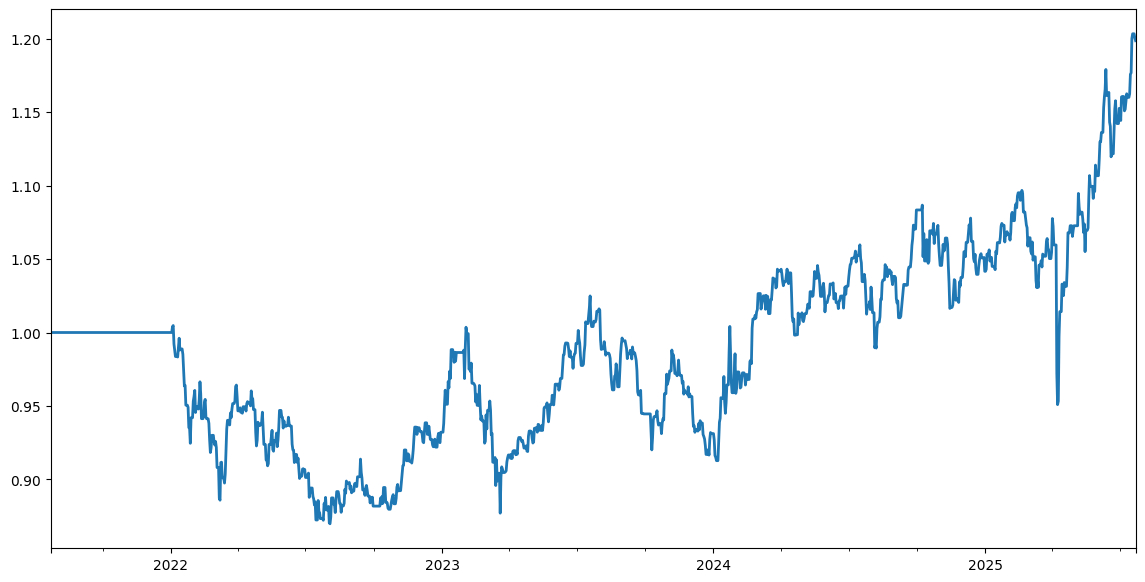

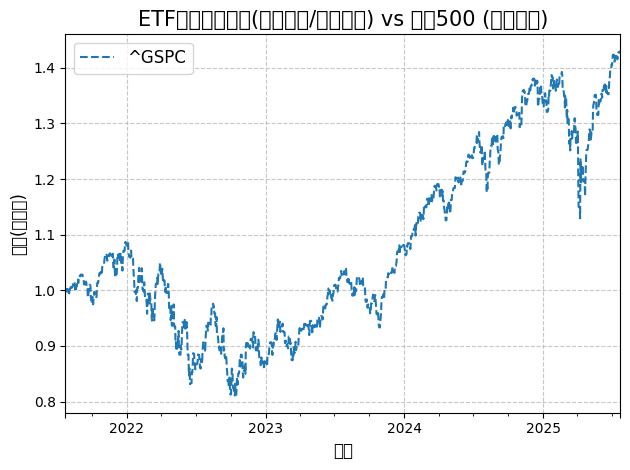

In [3]:
# 导入所需库
import yfinance as yf
import akshare as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 设置回测日期范围
end_date = datetime(2025, 7, 22)
start_date = end_date - timedelta(days=4*365)

# ================== 数据获取部分 ==================

# 获取国际ETF数据 (yfinance) - 加入SPY(标普500ETF)
intl_etfs = {
    'QQQ': '纳斯达克ETF',
    # 'SOYB': '大豆ETF',
    # 'GLD': '黄金ETF',
    # "BTC-USD":"Bitcoin",
    # 'SHY': 'usbond-ETF',
    'SPY': '标普500ETF'  # 新增SPY
}

intl_data = {}
for ticker, name in intl_etfs.items():
    print(f"获取{ticker}数据...")
    df = yf.download(ticker, start=start_date, end=end_date)
    if not df.empty:
        intl_data[ticker] = df[['Close']].rename(columns={'Close': 'close'})

# 获取标普500数据作为基准
print("获取标普500指数数据...")
sp500 = yf.download('^GSPC', start=start_date, end=end_date)[['Close']].rename(columns={'Close': 'close'})

# 获取中国ETF数据 (AKShare)
def fetch_etf_data_ak(symbol, start_date, end_date):
    """通过AKShare获取ETF数据"""
    try:
        df = ak.fund_etf_hist_em(symbol=symbol, period="daily", 
                                start_date=start_date.strftime("%Y%m%d"), 
                                end_date=end_date.strftime("%Y%m%d"), 
                                adjust="hfq")
        df = df.rename(columns={'日期':'date', '收盘':'close'})
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        return df[['close']]
    except Exception as e:
        print(f"获取{symbol}数据失败: {e}")
        return None

# 中国ETF列表
china_etfs = {
    # '159806': '新能源车etf',
    '513030': '德国etf',
    # '159980': '有色金属etf',
    '513010': '恒生科技',
    '513520': '日本etf',
    '159934': '黄金etf',
    '159985': '豆粕etf',
    '510880': '红利ETF',
    '513120': '创新药',
    '511010': '上证5年期国债ETF'
}

china_data = {}
for code, name in china_etfs.items():
    print(f"获取{name}({code})数据...")
    df = fetch_etf_data_ak(code, start_date, end_date)
    if df is not None and not df.empty:
        china_data[code] = df

# 合并所有ETF数据
all_etfs = {}
for ticker, df in intl_data.items():
    all_etfs[ticker] = df
    
for code, df in china_data.items():
    all_etfs[code] = df

# 确保所有数据都有相同的日期索引
all_dates = pd.date_range(start_date, end_date)
for ticker in all_etfs:
    all_etfs[ticker] = all_etfs[ticker].reindex(all_dates).fillna(method='ffill')

# 标准化标普500数据
sp500 = sp500.reindex(all_dates).fillna(method='ffill')

# ================== 策略回测部分 ==================

def quarterly_rotation_backtest(etf_data, start_date, end_date, initial_capital=100000):
    """
    季度轮动策略回测
    :param etf_data: 包含所有ETF数据的字典
    :param start_date: 回测开始日期
    :param end_date: 回测结束日期
    :param initial_capital: 初始资金(10万)
    :return: 回测结果DataFrame和季度选择记录
    """
    # 创建季度末日期序列（确保包含最后一个季度）
    quarters = pd.date_range(start_date, end_date, freq='Q')
    if end_date not in quarters:  # 如果结束日期不是季度末，则添加
        quarters = quarters.append(pd.DatetimeIndex([end_date]))
    
    # 初始化持仓和组合价值
    portfolio_value = pd.Series(index=pd.date_range(start_date, end_date), dtype=float)
    portfolio_value.iloc[0] = initial_capital
    current_holdings = {}  # {ticker: shares}
    current_cash = initial_capital
    
    # 存储季度选择记录
    quarterly_selections = []
    
    # 按季度循环
    for i in range(len(quarters)-1):
        quarter_start = quarters[i]
        quarter_end = quarters[i+1]
        
        # 计算过去一个季度的收益率
        prev_quarter_start = quarter_start - pd.offsets.QuarterEnd()
        returns = {}
        for ticker, df in etf_data.items():
            if prev_quarter_start in df.index and quarter_start in df.index:
                start_price = df.loc[prev_quarter_start, 'close']
                end_price = df.loc[quarter_start, 'close']
                # 确保获取的是标量值而不是Series
                if isinstance(start_price, pd.Series):
                    start_price = start_price.iloc[0]
                if isinstance(end_price, pd.Series):
                    end_price = end_price.iloc[0]
                returns[ticker] = (end_price - start_price) / start_price
        
        # 判断市场状态（使用SPY作为市场基准）
        market_return = returns.get('SPY', 0) if returns else 0
        is_bull_market = market_return > 0  # SPY上涨则为牛市
        
        # 根据市场状态选择策略
        if len(returns) >= 4:
            # 确保所有返回值都是标量
            valid_returns = {k: v for k, v in returns.items() if not isinstance(v, (pd.Series, pd.DataFrame))}
            
            if is_bull_market is False:
                # 牛市时采取反向轮动（选择表现最差的4只ETF）
                selected = sorted(valid_returns.items(), key=lambda x: x[1])[:4]
                strategy_name = "反向轮动(熊市)"
            else:
                # 熊市时采取动量轮动（选择表现最好的4只ETF）
                selected = sorted(valid_returns.items(), key=lambda x: x[1], reverse=True)[:4]
                strategy_name = "动量轮动(牛市)"
            
            selected_tickers = [x[0] for x in selected]
            selected_names = [intl_etfs.get(ticker, china_etfs.get(ticker, ticker)) for ticker in selected_tickers]
            quarterly_selections.append((quarter_start, selected_tickers, selected_names, strategy_name, market_return*100))
        else:
            # 如果没有足够数据，保持现金
            selected_tickers = []
            quarterly_selections.append((quarter_start, [], ["现金"], "现金", market_return*100))
        
        # 计算调仓日价格
        rebalance_prices = {}
        for ticker in selected_tickers:
            price = etf_data[ticker].loc[quarter_start, 'close']
            if isinstance(price, pd.Series):
                price = price.iloc[0]
            rebalance_prices[ticker] = price
        
        # 卖出当前持仓
        for ticker, shares in current_holdings.items():
            if quarter_start in etf_data[ticker].index:
                price = etf_data[ticker].loc[quarter_start, 'close']
                if isinstance(price, pd.Series):
                    price = price.iloc[0]
                current_cash += shares * price
        
        current_holdings = {}
        
        # 买入新持仓(每只基金分配25%资金)
        if selected_tickers:
            allocation = current_cash / len(selected_tickers)  # 4只基金各25%
            for ticker in selected_tickers:
                price = rebalance_prices[ticker]
                shares = allocation / price
                current_holdings[ticker] = shares
                current_cash -= shares * price
        
        # 计算本季度每日组合价值
        for date in pd.date_range(quarter_start, quarter_end):
            if date in portfolio_value.index:
                daily_value = current_cash
                for ticker, shares in current_holdings.items():
                    if date in etf_data[ticker].index:
                        price = etf_data[ticker].loc[date, 'close']
                        if isinstance(price, pd.Series):
                            price = price.iloc[0]
                        daily_value += shares * price
                portfolio_value.loc[date] = daily_value
    
    # 填充缺失值(前向填充)
    portfolio_value = portfolio_value.ffill()
    
    return portfolio_value, quarterly_selections

# 执行回测(初始资金设为10万)
portfolio_value, quarterly_selections = quarterly_rotation_backtest(all_etfs, start_date, end_date, initial_capital=100000)

# 计算每日收益率
daily_returns = portfolio_value.pct_change().dropna()

# ================== 绩效计算部分 ==================

def calculate_performance_metrics(portfolio_value, daily_returns, benchmark_returns):
    """
    计算绩效指标
    :param portfolio_value: 组合价值序列
    :param daily_returns: 每日收益率序列
    :param benchmark_returns: 基准收益率序列
    :return: 绩效指标字典
    """
    # 总收益率
    total_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0]) - 1
    
    # 年化收益率
    years = len(portfolio_value) / 252
    annualized_return = (1 + total_return) ** (1/years) - 1
    
    # 年化波动率
    annualized_volatility = daily_returns.std() * np.sqrt(252)
    
    # 夏普比率(假设无风险利率3%)
    risk_free_rate = 0.03
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    
    # 最大回撤
    cumulative_returns = (1 + daily_returns).cumprod()
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    
    # 确保日期对齐
    aligned_returns, aligned_benchmark = daily_returns.align(benchmark_returns, join='inner')
    aligned_returns_array = aligned_returns.values
    aligned_benchmark_array = aligned_benchmark.values
    
    # 检查并调整数组形状
    if aligned_returns_array.ndim > 1:
        aligned_returns_array = aligned_returns_array.flatten()
    if aligned_benchmark_array.ndim > 1:
        aligned_benchmark_array = aligned_benchmark_array.flatten()
    
    # 计算Beta
    covariance_matrix = np.cov(aligned_returns_array, aligned_benchmark_array)
    covariance = covariance_matrix[0, 1]
    benchmark_variance = np.var(aligned_benchmark_array)
    beta = covariance / benchmark_variance
    
    # 计算Alpha - 确保结果是标量值
    benchmark_annual_return = (1 + aligned_benchmark.mean()) ** 252 - 1
    if isinstance(benchmark_annual_return, pd.Series):
        benchmark_annual_return = benchmark_annual_return.iloc[0]
    alpha = float(annualized_return - (risk_free_rate + beta * (benchmark_annual_return - risk_free_rate)))
    
    # 分年度收益率
    yearly_returns = portfolio_value.resample('Y').last().pct_change()
    yearly_returns.index = yearly_returns.index.year
    yearly_returns = yearly_returns.dropna()
    
    return {
        '总收益率': total_return,
        '年化收益率': annualized_return,
        '年化波动率': annualized_volatility,
        '夏普比率': sharpe_ratio,
        '最大回撤': max_drawdown,
        'Alpha': alpha,
        'Beta': beta,
        '分年度收益率': yearly_returns
    }

# 计算标普500收益率
sp500_returns = sp500['close'].pct_change().dropna()

# 计算绩效指标
metrics = calculate_performance_metrics(portfolio_value, daily_returns, sp500_returns)

# ================== 结果展示部分 ==================

print("\n季度选择记录:")
for quarter in quarterly_selections:
    date = quarter[0].strftime('%Y-%m-%d')
    tickers = ", ".join(quarter[1])
    names = ", ".join(quarter[2])
    strategy = quarter[3]
    market_ret = quarter[4]
    print(f"{date}: 市场状态(SPY上季度收益:{market_ret:.1f}%) 策略: {strategy}")
    print(f"   选择基金: {tickers} ({names})")

print("\n策略绩效指标(5年回测):")
print(f"初始资金: 100,000元")
print(f"最终资金: {portfolio_value.iloc[-1]:,.2f}元")
print(f"总收益率: {metrics['总收益率']*100:.2f}%")
print(f"年化收益率: {metrics['年化收益率']*100:.2f}%")
print(f"年化波动率: {metrics['年化波动率']*100:.2f}%")
print(f"夏普比率: {metrics['夏普比率']:.2f}")
print(f"最大回撤: {metrics['最大回撤']*100:.2f}%")
print(f"Alpha(相对于标普500): {metrics['Alpha']*100:.2f}%")
print(f"Beta(相对于标普500): {metrics['Beta']:.2f}")

print("\n分年度收益率:")
for year, ret in metrics['分年度收益率'].items():
    print(f"{year}: {ret*100:.2f}%")

# 绘制组合价值曲线
plt.figure(figsize=(14, 7))
(portfolio_value / 100000).plot(label='策略净值(10万初始)', linewidth=2)

# 绘制标普500作为比较
(sp500['close'] / sp500['close'].iloc[0]).plot(label='标普500', linestyle='--')

plt.title('ETF季度轮动策略(牛市反向/熊市动量) vs 标普500 (标准化后)', fontsize=15)
plt.xlabel('日期', fontsize=12)
plt.ylabel('净值(标准化)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

获取QQQ数据...
获取SPY数据...
获取标普500指数数据...
获取有色金属etf(159980)数据...


获取恒生科技(513010)数据...
获取恒生医药(159892)数据...
获取黄金etf(159934)数据...
获取豆粕etf(159985)数据...
获取红利ETF(510880)数据...
获取稀土(516780)数据...

季度选择记录及收益率:
2021-09-30: 选择基金  (现金) | 季度收益率: 0.00%
2021-12-31: 选择基金 513010, 510880, 159985, 159934 (恒生科技, 红利ETF, 豆粕etf, 黄金etf) | 季度收益率: 5.08%
2022-03-31: 选择基金 159892, 513010, 516780, QQQ (恒生医药, 恒生科技, 稀土, 纳斯达克ETF) | 季度收益率: 3.17%
2022-06-30: 选择基金 QQQ, 159980, SPY, 159985 (纳斯达克ETF, 有色金属etf, 标普500ETF, 豆粕etf) | 季度收益率: 1.06%
2022-09-30: 选择基金 513010, 159892, 516780, SPY (恒生科技, 恒生医药, 稀土, 标普500ETF) | 季度收益率: 14.20%
2022-12-31: 选择基金 510880, 516780, QQQ, 159934 (红利ETF, 稀土, 纳斯达克ETF, 黄金etf) | 季度收益率: 9.17%
2023-03-31: 选择基金 159985, 159892, 159980, 513010 (豆粕etf, 恒生医药, 有色金属etf, 恒生科技) | 季度收益率: -2.90%
2023-06-30: 选择基金 159892, 513010, 516780, 159980 (恒生医药, 恒生科技, 稀土, 有色金属etf) | 季度收益率: -2.49%
2023-09-30: 选择基金 516780, SPY, QQQ, 513010 (稀土, 标普500ETF, 纳斯达克ETF, 恒生科技) | 季度收益率: 4.55%
2023-12-31: 选择基金 516780, 159985, 513010, 510880 (稀土, 豆粕etf, 恒生科技, 红利ETF) | 季度收益率: -0.37%
2024-03-31: 选择基金 159892

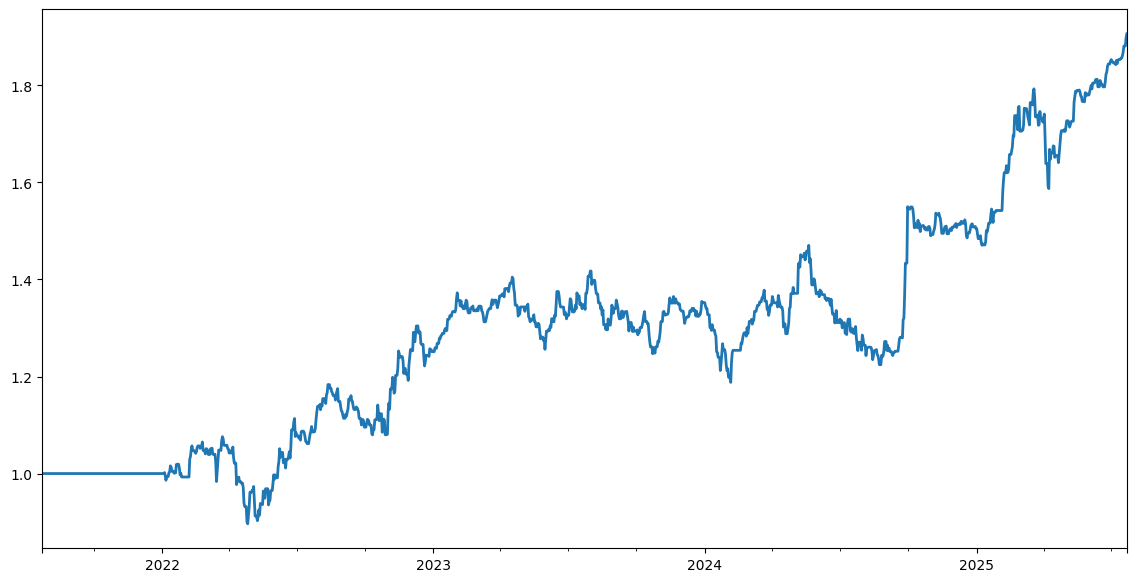

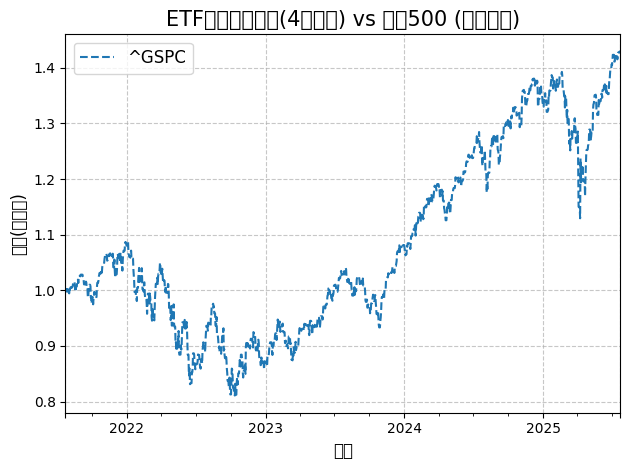

In [83]:
# 导入所需库
import yfinance as yf
import akshare as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 设置回测日期范围
end_date = datetime(2025, 7, 22)
start_date = end_date - timedelta(days=4*365)

# ================== 数据获取部分 ==================

# 获取国际ETF数据 (yfinance) - 加入SPY(标普500ETF)
intl_etfs = {
    'QQQ': '纳斯达克ETF',
    # 'SOYB': '大豆ETF',
    # 'GLD': '黄金ETF',
    # "BTC-USD":"Bitcoin",
    # 'SHY': 'usbond-ETF',
    'SPY': '标普500ETF'  # 新增SPY
}

intl_data = {}
for ticker, name in intl_etfs.items():
    print(f"获取{ticker}数据...")
    df = yf.download(ticker, start=start_date, end=end_date)
    if not df.empty:
        intl_data[ticker] = df[['Close']].rename(columns={'Close': 'close'})

# 获取标普500数据作为基准
print("获取标普500指数数据...")
sp500 = yf.download('^GSPC', start=start_date, end=end_date)[['Close']].rename(columns={'Close': 'close'})

# 获取中国ETF数据 (AKShare)
def fetch_etf_data_ak(symbol, start_date, end_date):
    """通过AKShare获取ETF数据"""
    try:
        df = ak.fund_etf_hist_em(symbol=symbol, period="daily", 
                                start_date=start_date.strftime("%Y%m%d"), 
                                end_date=end_date.strftime("%Y%m%d"), 
                                adjust="hfq")
        df = df.rename(columns={'日期':'date', '收盘':'close'})
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        return df[['close']]
    except Exception as e:
        print(f"获取{symbol}数据失败: {e}")
        return None

# 中国ETF列表
china_etfs = {
    # '159806': '新能源车etf',
    # '513030': '德国etf',
    '159980': '有色金属etf',
    '513010': '恒生科技',
    # '159740': '恒生科技2',
    # '513520': '日本etf',
    # '159819':'人工智能etf',
    '159892': '恒生医药',
    '159934': '黄金etf',
    '159985': '豆粕etf',
    '510880': '红利ETF',
    # '513120': '创新药',
    '516780': '稀土',
    # '588080': '科创50',
    # '511010': '上证5年期国债ETF'
}

china_data = {}
for code, name in china_etfs.items():
    print(f"获取{name}({code})数据...")
    df = fetch_etf_data_ak(code, start_date, end_date)
    if df is not None and not df.empty:
        china_data[code] = df

# 合并所有ETF数据
all_etfs = {}
for ticker, df in intl_data.items():
    all_etfs[ticker] = df
    
for code, df in china_data.items():
    all_etfs[code] = df

# 确保所有数据都有相同的日期索引
all_dates = pd.date_range(start_date, end_date)
for ticker in all_etfs:
    all_etfs[ticker] = all_etfs[ticker].reindex(all_dates).fillna(method='ffill')

# 标准化标普500数据
sp500 = sp500.reindex(all_dates).fillna(method='ffill')

# ================== 策略回测部分 ==================
def quarterly_rotation_backtest(etf_data, start_date, end_date, initial_capital=100000):
    """
    季度轮动策略回测（反转策略）
    :param etf_data: 包含所有ETF数据的字典
    :param start_date: 回测开始日期
    :param end_date: 回测结束日期
    :param initial_capital: 初始资金(10万)
    :return: 回测结果DataFrame和季度选择记录
    """
    # 创建季度末日期序列（确保包含最后一个季度）
    quarters = pd.date_range(start_date, end_date, freq='Q')
    if end_date not in quarters:  # 如果结束日期不是季度末，则添加
        quarters = quarters.append(pd.DatetimeIndex([end_date]))
    
    # 初始化持仓和组合价值
    portfolio_value = pd.Series(index=pd.date_range(start_date, end_date), dtype=float)
    portfolio_value.iloc[0] = initial_capital
    current_holdings = {}  # {ticker: shares}
    current_cash = initial_capital
    
    # 存储季度选择记录和季度收益率
    quarterly_selections = []
    quarterly_performance = []
    
    # 按季度循环
    for i in range(len(quarters)-1):
        quarter_start = quarters[i]
        quarter_end = quarters[i+1]
        
        # 计算过去一个季度的收益率
        prev_quarter_start = quarter_start - pd.offsets.QuarterEnd()
        returns = {}
        for ticker, df in etf_data.items():
            if prev_quarter_start in df.index and quarter_start in df.index:
                start_price = df.loc[prev_quarter_start, 'close']
                end_price = df.loc[quarter_start, 'close']
                # 确保获取的是标量值而不是Series
                if isinstance(start_price, pd.Series):
                    start_price = start_price.iloc[0]
                if isinstance(end_price, pd.Series):
                    end_price = end_price.iloc[0]
                returns[ticker] = (end_price - start_price) / start_price
        
        # 选择收益率最低的4只ETF（反转策略）
        if len(returns) >= 4:
            # 确保所有返回值都是标量
            valid_returns = {k: v for k, v in returns.items() if not isinstance(v, (pd.Series, pd.DataFrame))}
            selected = sorted(valid_returns.items(), key=lambda x: x[1])[:4]  # 改为升序排序，选择表现最差的
            selected_tickers = [x[0] for x in selected]
            selected_names = [intl_etfs.get(ticker, china_etfs.get(ticker, ticker)) for ticker in selected_tickers]
            quarterly_selections.append((quarter_start, selected_tickers, selected_names))
        else:
            # 如果没有足够数据，保持现金
            selected_tickers = []
            quarterly_selections.append((quarter_start, [], ["现金"]))
        
        # 计算调仓日价格
        rebalance_prices = {}
        for ticker in selected_tickers:
            price = etf_data[ticker].loc[quarter_start, 'close']
            if isinstance(price, pd.Series):
                price = price.iloc[0]
            rebalance_prices[ticker] = price
        
        # 卖出当前持仓
        for ticker, shares in current_holdings.items():
            if quarter_start in etf_data[ticker].index:
                price = etf_data[ticker].loc[quarter_start, 'close']
                if isinstance(price, pd.Series):
                    price = price.iloc[0]
                current_cash += shares * price
        
        current_holdings = {}
        
        # 买入新持仓(每只基金分配25%资金)
        if selected_tickers:
            allocation = current_cash / len(selected_tickers)  # 4只基金各25%
            for ticker in selected_tickers:
                price = rebalance_prices[ticker]
                shares = allocation / price
                current_holdings[ticker] = shares
                current_cash -= shares * price
        
        # 计算本季度每日组合价值
        quarter_values = []
        for date in pd.date_range(quarter_start, quarter_end):
            if date in portfolio_value.index:
                daily_value = current_cash
                for ticker, shares in current_holdings.items():
                    if date in etf_data[ticker].index:
                        price = etf_data[ticker].loc[date, 'close']
                        if isinstance(price, pd.Series):
                            price = price.iloc[0]
                        daily_value += shares * price
                portfolio_value.loc[date] = daily_value
                quarter_values.append(daily_value)
        
        # 计算本季度收益率
        if len(quarter_values) > 1:
            quarter_return = (quarter_values[-1] - quarter_values[0]) / quarter_values[0]
        else:
            quarter_return = 0
        quarterly_performance.append((quarter_start, quarter_return))
    
    # 填充缺失值(前向填充)
    portfolio_value = portfolio_value.ffill()
    
    return portfolio_value, quarterly_selections, quarterly_performance


# 执行回测(初始资金设为10万)
portfolio_value, quarterly_selections, quarterly_performance = quarterly_rotation_backtest(all_etfs, start_date, end_date, initial_capital=100000)

# 计算每日收益率
daily_returns = portfolio_value.pct_change().dropna()

# ================== 绩效计算部分 ==================

def calculate_performance_metrics(portfolio_value, daily_returns, benchmark_returns):
    """
    计算绩效指标
    :param portfolio_value: 组合价值序列
    :param daily_returns: 每日收益率序列
    :param benchmark_returns: 基准收益率序列
    :return: 绩效指标字典
    """
    # 总收益率
    total_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0]) - 1
    
    # 年化收益率
    years = len(portfolio_value) / 252
    annualized_return = (1 + total_return) ** (1/years) - 1
    
    # 年化波动率
    annualized_volatility = daily_returns.std() * np.sqrt(252)
    
    # 夏普比率(假设无风险利率3%)
    risk_free_rate = 0.03
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    
    # 最大回撤
    cumulative_returns = (1 + daily_returns).cumprod()
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    
    # 确保日期对齐
    aligned_returns, aligned_benchmark = daily_returns.align(benchmark_returns, join='inner')
    aligned_returns_array = aligned_returns.values
    aligned_benchmark_array = aligned_benchmark.values
    
    # 检查并调整数组形状
    if aligned_returns_array.ndim > 1:
        aligned_returns_array = aligned_returns_array.flatten()
    if aligned_benchmark_array.ndim > 1:
        aligned_benchmark_array = aligned_benchmark_array.flatten()
    
    # 计算Beta
    covariance_matrix = np.cov(aligned_returns_array, aligned_benchmark_array)
    covariance = covariance_matrix[0, 1]
    benchmark_variance = np.var(aligned_benchmark_array)
    beta = covariance / benchmark_variance
    
    # 计算Alpha - 确保结果是标量值
    benchmark_annual_return = (1 + aligned_benchmark.mean()) ** 252 - 1
    if isinstance(benchmark_annual_return, pd.Series):
        benchmark_annual_return = benchmark_annual_return.iloc[0]
    alpha = float(annualized_return - (risk_free_rate + beta * (benchmark_annual_return - risk_free_rate)))
    
    # 分年度收益率
    yearly_returns = portfolio_value.resample('Y').last().pct_change()
    yearly_returns.index = yearly_returns.index.year
    yearly_returns = yearly_returns.dropna()
    
    return {
        '总收益率': total_return,
        '年化收益率': annualized_return,
        '年化波动率': annualized_volatility,
        '夏普比率': sharpe_ratio,
        '最大回撤': max_drawdown,
        'Alpha': alpha,
        'Beta': beta,
        '分年度收益率': yearly_returns
    }

# 计算标普500收益率
sp500_returns = sp500['close'].pct_change().dropna()

# 计算绩效指标
metrics = calculate_performance_metrics(portfolio_value, daily_returns, sp500_returns)

# ================== 结果展示部分 ==================

# print("\n季度选择记录:")
# for quarter in quarterly_selections:
#     date = quarter[0].strftime('%Y-%m-%d')
#     tickers = ", ".join(quarter[1])
#     names = ", ".join(quarter[2])
#     print(f"{date}: 选择基金 {tickers} ({names})")

print("\n季度选择记录及收益率:")
for i, quarter in enumerate(quarterly_selections):
    date = quarter[0].strftime('%Y-%m-%d')
    tickers = ", ".join(quarter[1])
    names = ", ".join(quarter[2])
    q_return = quarterly_performance[i][1] * 100
    print(f"{date}: 选择基金 {tickers} ({names}) | 季度收益率: {q_return:.2f}%")

print("\n策略绩效指标(5年回测):")
print(f"初始资金: 100,000元")
print(f"最终资金: {portfolio_value.iloc[-1]:,.2f}元")
print(f"总收益率: {metrics['总收益率']*100:.2f}%")
print(f"年化收益率: {metrics['年化收益率']*100:.2f}%")
print(f"年化波动率: {metrics['年化波动率']*100:.2f}%")
print(f"夏普比率: {metrics['夏普比率']:.2f}")
print(f"最大回撤: {metrics['最大回撤']*100:.2f}%")
print(f"Alpha(相对于标普500): {metrics['Alpha']*100:.2f}%")
print(f"Beta(相对于标普500): {metrics['Beta']:.2f}")

print("\n分年度收益率:")
for year, ret in metrics['分年度收益率'].items():
    print(f"{year}: {ret*100:.2f}%")

# 绘制组合价值曲线
plt.figure(figsize=(14, 7))
(portfolio_value / 100000).plot(label='策略净值(10万初始)', linewidth=2)

# 绘制标普500作为比较
(sp500['close'] / sp500['close'].iloc[0]).plot(label='标普500', linestyle='--')

plt.title('ETF季度反转策略(4只基金) vs 标普500 (标准化后)', fontsize=15)
plt.xlabel('日期', fontsize=12)
plt.ylabel('净值(标准化)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

获取QQQ数据...
获取SPY数据...
获取标普500指数数据...
获取有色金属etf(159980)数据...


获取恒生科技(513010)数据...
获取恒生医药(159892)数据...
获取黄金etf(159934)数据...
获取豆粕etf(159985)数据...
获取红利ETF(510880)数据...
获取稀土(516780)数据...

季度选择记录及策略:
2021-09-30: 现金 | 选择: 现金 (现金) | 季度收益率: 0.00%
2021-12-31: 1234名(上季度盈利) | 选择: 513010, 510880, 159985, 159934 (恒生科技, 红利ETF, 豆粕etf, 黄金etf) | 季度收益率: 5.08%
2022-03-31: 1234名(上季度盈利) | 选择: 159892, 513010, 516780, QQQ (恒生医药, 恒生科技, 稀土, 纳斯达克ETF) | 季度收益率: 3.17%
2022-06-30: 1234名(上季度盈利) | 选择: QQQ, 159980, SPY, 159985 (纳斯达克ETF, 有色金属etf, 标普500ETF, 豆粕etf) | 季度收益率: 1.06%
2022-09-30: 1234名(上季度盈利) | 选择: 513010, 159892, 516780, SPY (恒生科技, 恒生医药, 稀土, 标普500ETF) | 季度收益率: 14.20%
2022-12-31: 1234名(上季度盈利) | 选择: 510880, 516780, QQQ, 159934 (红利ETF, 稀土, 纳斯达克ETF, 黄金etf) | 季度收益率: 9.17%
2023-03-31: 1234名(上季度盈利) | 选择: 159985, 159892, 159980, 513010 (豆粕etf, 恒生医药, 有色金属etf, 恒生科技) | 季度收益率: -2.90%
2023-06-30: 3456名(上季度亏损) | 选择: 513010, 516780, 159980, 510880 (恒生科技, 稀土, 有色金属etf, 红利ETF) | 季度收益率: -1.68%
2023-09-30: 3456名(上季度亏损) | 选择: SPY, QQQ, 513010, 159892 (标普500ETF, 纳斯达克ETF, 恒生科技, 恒生医药) | 季度收益率

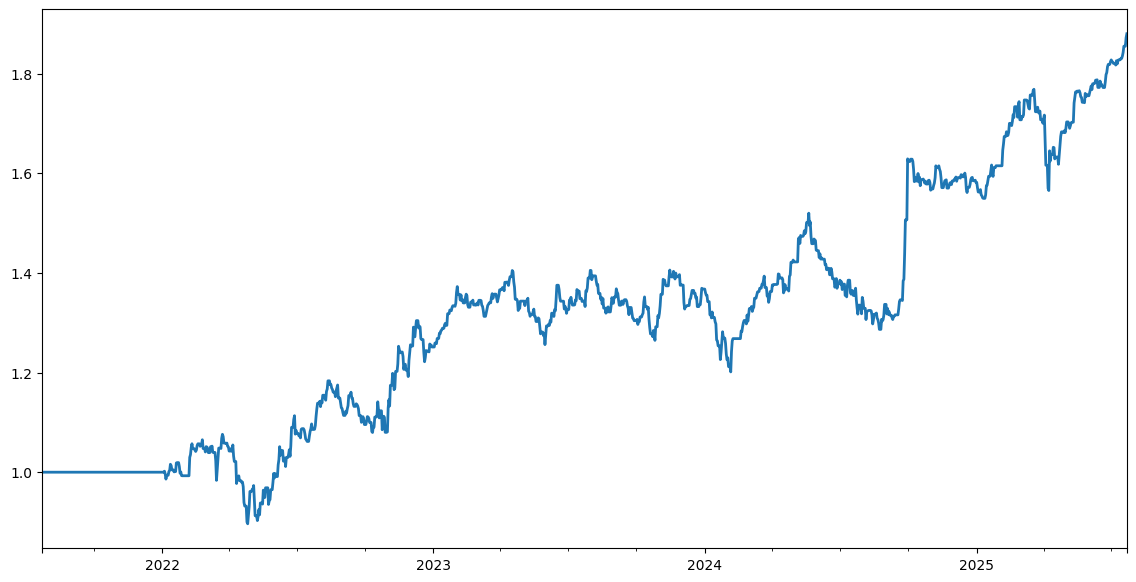

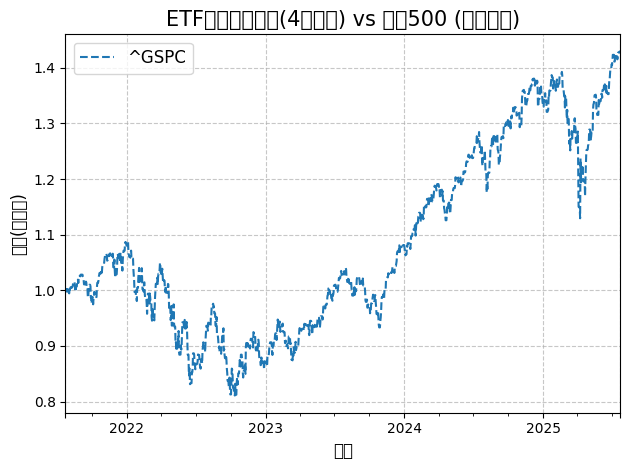

In [85]:
# 导入所需库
import yfinance as yf
import akshare as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 设置回测日期范围
end_date = datetime(2025, 7, 22)
start_date = end_date - timedelta(days=4*365)

# ================== 数据获取部分 ==================

# 获取国际ETF数据 (yfinance) - 加入SPY(标普500ETF)
intl_etfs = {
    'QQQ': '纳斯达克ETF',
    # 'SOYB': '大豆ETF',
    # 'GLD': '黄金ETF',
    # "BTC-USD":"Bitcoin",
    # 'SHY': 'usbond-ETF',
    'SPY': '标普500ETF'  # 新增SPY
}

intl_data = {}
for ticker, name in intl_etfs.items():
    print(f"获取{ticker}数据...")
    df = yf.download(ticker, start=start_date, end=end_date)
    if not df.empty:
        intl_data[ticker] = df[['Close']].rename(columns={'Close': 'close'})

# 获取标普500数据作为基准
print("获取标普500指数数据...")
sp500 = yf.download('^GSPC', start=start_date, end=end_date)[['Close']].rename(columns={'Close': 'close'})

# 获取中国ETF数据 (AKShare)
def fetch_etf_data_ak(symbol, start_date, end_date):
    """通过AKShare获取ETF数据"""
    try:
        df = ak.fund_etf_hist_em(symbol=symbol, period="daily", 
                                start_date=start_date.strftime("%Y%m%d"), 
                                end_date=end_date.strftime("%Y%m%d"), 
                                adjust="hfq")
        df = df.rename(columns={'日期':'date', '收盘':'close'})
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        return df[['close']]
    except Exception as e:
        print(f"获取{symbol}数据失败: {e}")
        return None

# 中国ETF列表
china_etfs = {
    # '159806': '新能源车etf',
    # '513030': '德国etf',
    '159980': '有色金属etf',
    '513010': '恒生科技',
    # '159740': '恒生科技2',
    # '513520': '日本etf',
    # '159819':'人工智能etf',
    '159892': '恒生医药',
    '159934': '黄金etf',
    '159985': '豆粕etf',
    '510880': '红利ETF',
    # '513120': '创新药',
    '516780': '稀土',
    # '588080': '科创50',
    # '511010': '上证5年期国债ETF'
}

china_data = {}
for code, name in china_etfs.items():
    print(f"获取{name}({code})数据...")
    df = fetch_etf_data_ak(code, start_date, end_date)
    if df is not None and not df.empty:
        china_data[code] = df

# 合并所有ETF数据
all_etfs = {}
for ticker, df in intl_data.items():
    all_etfs[ticker] = df
    
for code, df in china_data.items():
    all_etfs[code] = df

# 确保所有数据都有相同的日期索引
all_dates = pd.date_range(start_date, end_date)
for ticker in all_etfs:
    all_etfs[ticker] = all_etfs[ticker].reindex(all_dates).fillna(method='ffill')

# 标准化标普500数据
sp500 = sp500.reindex(all_dates).fillna(method='ffill')

# ================== 策略回测部分 ==================
def quarterly_rotation_backtest(etf_data, start_date, end_date, initial_capital=100000):
    """
    季度轮动策略回测（动态反转策略）
    规则：如果上季度收益为负，选取排名3-6名；如果收益为正，选取排名1-4名
    """
    # 创建季度末日期序列
    quarters = pd.date_range(start_date, end_date, freq='Q')
    if end_date not in quarters:
        quarters = quarters.append(pd.DatetimeIndex([end_date]))
    
    # 初始化
    portfolio_value = pd.Series(index=pd.date_range(start_date, end_date), dtype=float)
    portfolio_value.iloc[0] = initial_capital
    current_holdings = {}
    current_cash = initial_capital
    
    quarterly_selections = []
    quarterly_performance = []
    last_quarter_return = 0  # 记录上季度收益率
    
    for i in range(len(quarters)-1):
        quarter_start = quarters[i]
        quarter_end = quarters[i+1]
        
        # 计算过去一个季度的收益率
        prev_quarter_start = quarter_start - pd.offsets.QuarterEnd()
        returns = {}
        for ticker, df in etf_data.items():
            if prev_quarter_start in df.index and quarter_start in df.index:
                start_price = df.loc[prev_quarter_start, 'close']
                end_price = df.loc[quarter_start, 'close']
                if isinstance(start_price, pd.Series):
                    start_price = start_price.iloc[0]
                if isinstance(end_price, pd.Series):
                    end_price = end_price.iloc[0]
                returns[ticker] = (end_price - start_price) / start_price
        
        # 动态选择ETF：根据上季度收益决定选择范围
        if len(returns) >= 6:  # 需要至少6只ETF才能执行3456选择
            valid_returns = {k: v for k, v in returns.items() if not isinstance(v, (pd.Series, pd.DataFrame))}
            sorted_returns = sorted(valid_returns.items(), key=lambda x: x[1])  # 升序排序
            
            # 根据上季度收益决定选择范围
            if last_quarter_return < 0:  # 上季度亏损，选择3-6名
                selected = sorted_returns[1:5]
                selection_type = "2345名(上季度亏损)"
            else:  # 上季度盈利，选择1-4名
                selected = sorted_returns[:4]
                selection_type = "1234名(上季度盈利)"
                
            selected_tickers = [x[0] for x in selected]
            selected_names = [intl_etfs.get(ticker, china_etfs.get(ticker, ticker)) for ticker in selected_tickers]
            quarterly_selections.append((quarter_start, selected_tickers, selected_names, selection_type))
        elif len(returns) >= 4:  # 回退到原始逻辑
            valid_returns = {k: v for k, v in returns.items() if not isinstance(v, (pd.Series, pd.DataFrame))}
            selected = sorted(valid_returns.items(), key=lambda x: x[1])[:4]
            selected_tickers = [x[0] for x in selected]
            selected_names = [intl_etfs.get(ticker, china_etfs.get(ticker, ticker)) for ticker in selected_tickers]
            quarterly_selections.append((quarter_start, selected_tickers, selected_names, "1234名(默认)"))
        else:
            selected_tickers = []
            quarterly_selections.append((quarter_start, [], ["现金"], "现金"))
        
        # 计算调仓日价格
        rebalance_prices = {}
        for ticker in selected_tickers:
            price = etf_data[ticker].loc[quarter_start, 'close']
            if isinstance(price, pd.Series):
                price = price.iloc[0]
            rebalance_prices[ticker] = price
        
        # 卖出当前持仓
        for ticker, shares in current_holdings.items():
            if quarter_start in etf_data[ticker].index:
                price = etf_data[ticker].loc[quarter_start, 'close']
                if isinstance(price, pd.Series):
                    price = price.iloc[0]
                current_cash += shares * price
        
        current_holdings = {}
        
        # 买入新持仓(等权分配)
        if selected_tickers:
            allocation = current_cash / len(selected_tickers)
            for ticker in selected_tickers:
                price = rebalance_prices[ticker]
                shares = allocation / price
                current_holdings[ticker] = shares
                current_cash -= shares * price
        
        # 计算本季度每日组合价值
        quarter_values = []
        for date in pd.date_range(quarter_start, quarter_end):
            if date in portfolio_value.index:
                daily_value = current_cash
                for ticker, shares in current_holdings.items():
                    if date in etf_data[ticker].index:
                        price = etf_data[ticker].loc[date, 'close']
                        if isinstance(price, pd.Series):
                            price = price.iloc[0]
                        daily_value += shares * price
                portfolio_value.loc[date] = daily_value
                quarter_values.append(daily_value)
        
        # 计算本季度收益率并记录
        if len(quarter_values) > 1:
            last_quarter_return = (quarter_values[-1] - quarter_values[0]) / quarter_values[0]
        else:
            last_quarter_return = 0
        quarterly_performance.append((quarter_start, last_quarter_return))
    
    portfolio_value = portfolio_value.ffill()
    return portfolio_value, quarterly_selections, quarterly_performance

# 执行回测
portfolio_value, quarterly_selections, quarterly_performance = quarterly_rotation_backtest(all_etfs, start_date, end_date)

# 计算每日收益率
daily_returns = portfolio_value.pct_change().dropna()

# ================== 绩效计算部分 ==================

def calculate_performance_metrics(portfolio_value, daily_returns, benchmark_returns):
    """
    计算绩效指标
    :param portfolio_value: 组合价值序列
    :param daily_returns: 每日收益率序列
    :param benchmark_returns: 基准收益率序列
    :return: 绩效指标字典
    """
    # 总收益率
    total_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0]) - 1
    
    # 年化收益率
    years = len(portfolio_value) / 252
    annualized_return = (1 + total_return) ** (1/years) - 1
    
    # 年化波动率
    annualized_volatility = daily_returns.std() * np.sqrt(252)
    
    # 夏普比率(假设无风险利率3%)
    risk_free_rate = 0.03
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    
    # 最大回撤
    cumulative_returns = (1 + daily_returns).cumprod()
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    
    # 确保日期对齐
    aligned_returns, aligned_benchmark = daily_returns.align(benchmark_returns, join='inner')
    aligned_returns_array = aligned_returns.values
    aligned_benchmark_array = aligned_benchmark.values
    
    # 检查并调整数组形状
    if aligned_returns_array.ndim > 1:
        aligned_returns_array = aligned_returns_array.flatten()
    if aligned_benchmark_array.ndim > 1:
        aligned_benchmark_array = aligned_benchmark_array.flatten()
    
    # 计算Beta
    covariance_matrix = np.cov(aligned_returns_array, aligned_benchmark_array)
    covariance = covariance_matrix[0, 1]
    benchmark_variance = np.var(aligned_benchmark_array)
    beta = covariance / benchmark_variance
    
    # 计算Alpha - 确保结果是标量值
    benchmark_annual_return = (1 + aligned_benchmark.mean()) ** 252 - 1
    if isinstance(benchmark_annual_return, pd.Series):
        benchmark_annual_return = benchmark_annual_return.iloc[0]
    alpha = float(annualized_return - (risk_free_rate + beta * (benchmark_annual_return - risk_free_rate)))
    
    # 分年度收益率
    yearly_returns = portfolio_value.resample('Y').last().pct_change()
    yearly_returns.index = yearly_returns.index.year
    yearly_returns = yearly_returns.dropna()
    
    return {
        '总收益率': total_return,
        '年化收益率': annualized_return,
        '年化波动率': annualized_volatility,
        '夏普比率': sharpe_ratio,
        '最大回撤': max_drawdown,
        'Alpha': alpha,
        'Beta': beta,
        '分年度收益率': yearly_returns
    }

# 计算标普500收益率
sp500_returns = sp500['close'].pct_change().dropna()

# 计算绩效指标
metrics = calculate_performance_metrics(portfolio_value, daily_returns, sp500_returns)

# ================== 结果展示部分 ==================

# print("\n季度选择记录:")
# for quarter in quarterly_selections:
#     date = quarter[0].strftime('%Y-%m-%d')
#     tickers = ", ".join(quarter[1])
#     names = ", ".join(quarter[2])
#     print(f"{date}: 选择基金 {tickers} ({names})")

print("\n季度选择记录及策略:")
for i, quarter in enumerate(quarterly_selections):
    date = quarter[0].strftime('%Y-%m-%d')
    tickers = ", ".join(quarter[1]) if quarter[1] else "现金"
    names = ", ".join(quarter[2]) if quarter[2] else "现金"
    strategy = quarter[3]  # 新增的策略类型信息
    q_return = quarterly_performance[i][1] * 100
    print(f"{date}: {strategy} | 选择: {tickers} ({names}) | 季度收益率: {q_return:.2f}%")

print("\n策略绩效指标(5年回测):")
print(f"初始资金: 100,000元")
print(f"最终资金: {portfolio_value.iloc[-1]:,.2f}元")
print(f"总收益率: {metrics['总收益率']*100:.2f}%")
print(f"年化收益率: {metrics['年化收益率']*100:.2f}%")
print(f"年化波动率: {metrics['年化波动率']*100:.2f}%")
print(f"夏普比率: {metrics['夏普比率']:.2f}")
print(f"最大回撤: {metrics['最大回撤']*100:.2f}%")
print(f"Alpha(相对于标普500): {metrics['Alpha']*100:.2f}%")
print(f"Beta(相对于标普500): {metrics['Beta']:.2f}")

print("\n分年度收益率:")
for year, ret in metrics['分年度收益率'].items():
    print(f"{year}: {ret*100:.2f}%")

# 绘制组合价值曲线
plt.figure(figsize=(14, 7))
(portfolio_value / 100000).plot(label='策略净值(10万初始)', linewidth=2)

# 绘制标普500作为比较
(sp500['close'] / sp500['close'].iloc[0]).plot(label='标普500', linestyle='--')

plt.title('ETF季度反转策略(4只基金) vs 标普500 (标准化后)', fontsize=15)
plt.xlabel('日期', fontsize=12)
plt.ylabel('净值(标准化)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

获取QQQ数据...
获取SPY数据...
获取标普500指数数据...
获取有色金属etf(159980)数据...


获取恒生科技(513010)数据...
获取恒生医药(159892)数据...
获取黄金etf(159934)数据...
获取豆粕etf(159985)数据...
获取红利ETF(510880)数据...
获取稀土(516780)数据...

季度选择记录及收益率:
2020-09-30: 选择基金 现金 (现金) | 季度收益率: 0.00%
2020-12-31: 选择基金 159934, 510880, 159980, SPY (黄金etf, 红利ETF, 有色金属etf, 标普500ETF) | 季度收益率: 2.49%
2021-03-31: 选择基金 QQQ, SPY, 159980, 513010 (纳斯达克ETF, 标普500ETF, 有色金属etf, 恒生科技) | 季度收益率: nan%
2021-06-30: 选择基金 159934, 510880, 159985, 159980 (黄金etf, 红利ETF, 豆粕etf, 有色金属etf) | 季度收益率: nan%
2021-09-30: 选择基金 513010, 159934, SPY, 159985 (恒生科技, 黄金etf, 标普500ETF, 豆粕etf) | 季度收益率: nan%
2021-12-31: 选择基金 513010, 510880, 159985, 159934 (恒生科技, 红利ETF, 豆粕etf, 黄金etf) | 季度收益率: nan%
2022-03-31: 选择基金 159892, 513010, 516780, QQQ (恒生医药, 恒生科技, 稀土, 纳斯达克ETF) | 季度收益率: nan%
2022-06-30: 选择基金 QQQ, 159980, SPY, 159985 (纳斯达克ETF, 有色金属etf, 标普500ETF, 豆粕etf) | 季度收益率: nan%
2022-09-30: 选择基金 513010, 159892, 516780, SPY (恒生科技, 恒生医药, 稀土, 标普500ETF) | 季度收益率: nan%
2022-12-31: 选择基金 510880, 516780, QQQ, 159934 (红利ETF, 稀土, 纳斯达克ETF, 黄金etf) | 季度收益率: nan%
2023-03-31: 选择基金 1

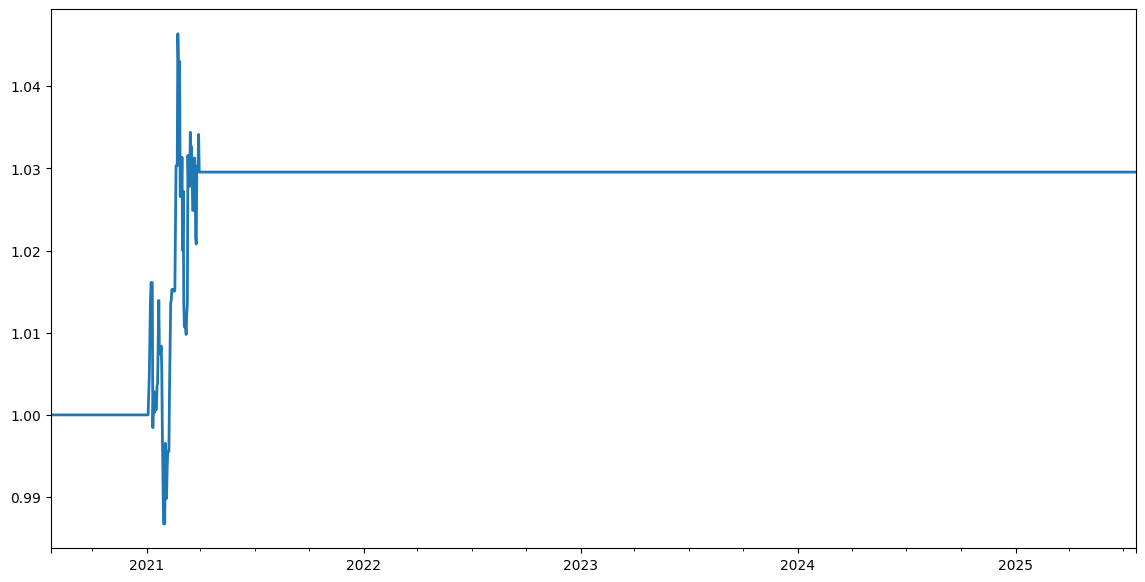

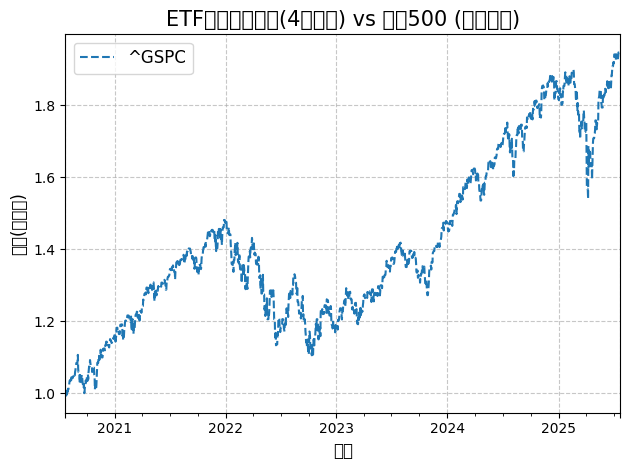

In [95]:
# 导入所需库
import yfinance as yf
import akshare as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 设置回测日期范围
end_date = datetime(2025, 7, 22)
start_date = end_date - timedelta(days=4*365)

# ================== 数据获取部分 ==================

# 获取国际ETF数据 (yfinance) - 加入SPY(标普500ETF)
intl_etfs = {
    'QQQ': '纳斯达克ETF',
    # 'SOYB': '大豆ETF',
    # 'GLD': '黄金ETF',
    # "BTC-USD":"Bitcoin",
    # 'SHY': 'usbond-ETF',
    'SPY': '标普500ETF'  # 新增SPY
}

intl_data = {}
for ticker, name in intl_etfs.items():
    print(f"获取{ticker}数据...")
    df = yf.download(ticker, start=start_date, end=end_date)
    if not df.empty:
        intl_data[ticker] = df[['Close']].rename(columns={'Close': 'close'})

# 获取标普500数据作为基准
print("获取标普500指数数据...")
sp500 = yf.download('^GSPC', start=start_date, end=end_date)[['Close']].rename(columns={'Close': 'close'})

# 获取中国ETF数据 (AKShare)
def fetch_etf_data_ak(symbol, start_date, end_date):
    """通过AKShare获取ETF数据"""
    try:
        df = ak.fund_etf_hist_em(symbol=symbol, period="daily", 
                                start_date=start_date.strftime("%Y%m%d"), 
                                end_date=end_date.strftime("%Y%m%d"), 
                                adjust="hfq")
        df = df.rename(columns={'日期':'date', '收盘':'close'})
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        return df[['close']]
    except Exception as e:
        print(f"获取{symbol}数据失败: {e}")
        return None

# 中国ETF列表
china_etfs = {
    # '159806': '新能源车etf',
    # '513030': '德国etf',
    '159980': '有色金属etf',
    '513010': '恒生科技',
    # '159740': '恒生科技2',
    # '513520': '日本etf',
    # '159819':'人工智能etf',
    '159892': '恒生医药',
    '159934': '黄金etf',
    '159985': '豆粕etf',
    '510880': '红利ETF',
    # '513120': '创新药',
    '516780': '稀土',
    # '588080': '科创50',
    # '511010': '上证5年期国债ETF'
}

china_data = {}
for code, name in china_etfs.items():
    print(f"获取{name}({code})数据...")
    df = fetch_etf_data_ak(code, start_date, end_date)
    if df is not None and not df.empty:
        china_data[code] = df

# 合并所有ETF数据
all_etfs = {}
for ticker, df in intl_data.items():
    all_etfs[ticker] = df
    
for code, df in china_data.items():
    all_etfs[code] = df

# 确保所有数据都有相同的日期索引
all_dates = pd.date_range(start_date, end_date)
for ticker in all_etfs:
    all_etfs[ticker] = all_etfs[ticker].reindex(all_dates).fillna(method='ffill')

# 标准化标普500数据
sp500 = sp500.reindex(all_dates).fillna(method='ffill')


def quarterly_rotation_backtest(etf_data, start_date, end_date, initial_capital=100000):
    """
    季度再平衡策略回测
    规则：只有上季度不在选的基金才重新调仓，已持有的只做再平衡
    """
    # 创建季度末日期序列
    quarters = pd.date_range(start_date, end_date, freq='Q')
    if end_date not in quarters:
        quarters = quarters.append(pd.DatetimeIndex([end_date]))
    
    # 初始化
    portfolio_value = pd.Series(index=pd.date_range(start_date, end_date), dtype=float)
    portfolio_value.iloc[0] = initial_capital
    current_holdings = {}  # {ticker: shares}
    current_cash = initial_capital
    last_selected = set()  # 记录上季度选择的ETF
    
    quarterly_selections = []
    quarterly_performance = []
    
    for i in range(len(quarters)-1):
        quarter_start = quarters[i]
        quarter_end = quarters[i+1]
        
        # 计算过去一个季度的收益率
        prev_quarter_start = quarter_start - pd.offsets.QuarterEnd()
        returns = {}
        for ticker, df in etf_data.items():
            if prev_quarter_start in df.index and quarter_start in df.index:
                start_price = df.loc[prev_quarter_start, 'close']
                end_price = df.loc[quarter_start, 'close']
                if isinstance(start_price, pd.Series):
                    start_price = start_price.iloc[0]
                if isinstance(end_price, pd.Series):
                    end_price = end_price.iloc[0]
                returns[ticker] = (end_price - start_price) / start_price
        
        # 选择收益率最低的4只ETF
        if len(returns) >= 4:
            valid_returns = {k: v for k, v in returns.items() if not isinstance(v, (pd.Series, pd.DataFrame))}
            selected = sorted(valid_returns.items(), key=lambda x: x[1])[:4]
            selected_tickers = [x[0] for x in selected]
            selected_names = [intl_etfs.get(ticker, china_etfs.get(ticker, ticker)) for ticker in selected_tickers]
            quarterly_selections.append((quarter_start, selected_tickers, selected_names))
        else:
            selected_tickers = []
            quarterly_selections.append((quarter_start, [], ["现金"]))
        
        # 计算调仓日价格（确保获取标量值）
        rebalance_prices = {}
        for ticker in selected_tickers:
            price = etf_data[ticker].loc[quarter_start, 'close']
            if isinstance(price, pd.Series):
                price = price.iloc[0]  # 确保获取标量值
            rebalance_prices[ticker] = price
        
        # 卖出不在新选择中的持仓
        to_sell = set(current_holdings.keys()) - set(selected_tickers)
        for ticker in to_sell:
            if quarter_start in etf_data[ticker].index:
                price = etf_data[ticker].loc[quarter_start, 'close']
                if isinstance(price, pd.Series):
                    price = price.iloc[0]  # 确保获取标量值
                current_cash += current_holdings[ticker] * price
                del current_holdings[ticker]
        
        # 计算当前总价值
        total_value = current_cash
        for ticker, shares in current_holdings.items():
            if quarter_start in etf_data[ticker].index:
                price = etf_data[ticker].loc[quarter_start, 'close']
                if isinstance(price, pd.Series):
                    price = price.iloc[0]  # 确保获取标量值
                total_value += shares * price
        
        # 买入新增的ETF
        to_buy = set(selected_tickers) - set(current_holdings.keys())
        if to_buy:
            allocation = total_value / len(selected_tickers)  # 每只ETF的目标金额
            
            # 先调整现有持仓
            for ticker in set(current_holdings.keys()) & set(selected_tickers):
                current_value = current_holdings[ticker] * rebalance_prices[ticker]
                delta = allocation - current_value
                if delta > 0:  # 需要买入更多
                    shares_to_buy = delta / rebalance_prices[ticker]
                    current_holdings[ticker] += shares_to_buy
                    current_cash -= shares_to_buy * rebalance_prices[ticker]
                elif delta < 0:  # 需要卖出部分
                    shares_to_sell = -delta / rebalance_prices[ticker]
                    current_holdings[ticker] -= shares_to_sell
                    current_cash += shares_to_sell * rebalance_prices[ticker]
            
            # 再买入新增的ETF
            for ticker in to_buy:
                shares = allocation / rebalance_prices[ticker]
                current_holdings[ticker] = shares
                current_cash -= shares * rebalance_prices[ticker]
        
        # 如果没有新增的ETF，只需再平衡现有持仓
        elif current_holdings:
            allocation = total_value / len(current_holdings)
            
            for ticker in current_holdings:
                current_value = current_holdings[ticker] * rebalance_prices[ticker]
                delta = allocation - current_value
                if delta > 0:  # 需要买入更多
                    shares_to_buy = delta / rebalance_prices[ticker]
                    current_holdings[ticker] += shares_to_buy
                    current_cash -= shares_to_buy * rebalance_prices[ticker]
                elif delta < 0:  # 需要卖出部分
                    shares_to_sell = -delta / rebalance_prices[ticker]
                    current_holdings[ticker] -= shares_to_sell
                    current_cash += shares_to_sell * rebalance_prices[ticker]
        
        # 计算本季度每日组合价值
        quarter_values = []
        for date in pd.date_range(quarter_start, quarter_end):
            if date in portfolio_value.index:
                daily_value = current_cash
                for ticker, shares in current_holdings.items():
                    if date in etf_data[ticker].index:
                        price = etf_data[ticker].loc[date, 'close']
                        if isinstance(price, pd.Series):
                            price = price.iloc[0]  # 确保获取标量值
                        daily_value += shares * price
                portfolio_value.loc[date] = daily_value
                quarter_values.append(daily_value)
        
        # 计算本季度收益率
        if len(quarter_values) > 1:
            quarter_return = (quarter_values[-1] - quarter_values[0]) / quarter_values[0]
        else:
            quarter_return = 0
        quarterly_performance.append((quarter_start, quarter_return))
        
        # 更新上季度选择的ETF
        last_selected = set(selected_tickers)
    
    portfolio_value = portfolio_value.ffill()
    return portfolio_value, quarterly_selections, quarterly_performance

# 执行回测
portfolio_value, quarterly_selections, quarterly_performance = quarterly_rotation_backtest(all_etfs, start_date, end_date)

# 计算每日收益率
daily_returns = portfolio_value.pct_change().dropna()

# ================== 绩效计算部分 ==================

def calculate_performance_metrics(portfolio_value, daily_returns, benchmark_returns):
    """
    计算绩效指标
    :param portfolio_value: 组合价值序列
    :param daily_returns: 每日收益率序列
    :param benchmark_returns: 基准收益率序列
    :return: 绩效指标字典
    """
    # 总收益率
    total_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0]) - 1
    
    # 年化收益率
    years = len(portfolio_value) / 252
    annualized_return = (1 + total_return) ** (1/years) - 1
    
    # 年化波动率
    annualized_volatility = daily_returns.std() * np.sqrt(252)
    
    # 夏普比率(假设无风险利率3%)
    risk_free_rate = 0.03
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    
    # 最大回撤
    cumulative_returns = (1 + daily_returns).cumprod()
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    
    # 确保日期对齐
    aligned_returns, aligned_benchmark = daily_returns.align(benchmark_returns, join='inner')
    aligned_returns_array = aligned_returns.values
    aligned_benchmark_array = aligned_benchmark.values
    
    # 检查并调整数组形状
    if aligned_returns_array.ndim > 1:
        aligned_returns_array = aligned_returns_array.flatten()
    if aligned_benchmark_array.ndim > 1:
        aligned_benchmark_array = aligned_benchmark_array.flatten()
    
    # 计算Beta
    covariance_matrix = np.cov(aligned_returns_array, aligned_benchmark_array)
    covariance = covariance_matrix[0, 1]
    benchmark_variance = np.var(aligned_benchmark_array)
    beta = covariance / benchmark_variance
    
    # 计算Alpha - 确保结果是标量值
    benchmark_annual_return = (1 + aligned_benchmark.mean()) ** 252 - 1
    if isinstance(benchmark_annual_return, pd.Series):
        benchmark_annual_return = benchmark_annual_return.iloc[0]
    alpha = float(annualized_return - (risk_free_rate + beta * (benchmark_annual_return - risk_free_rate)))
    
    # 分年度收益率
    yearly_returns = portfolio_value.resample('Y').last().pct_change()
    yearly_returns.index = yearly_returns.index.year
    yearly_returns = yearly_returns.dropna()
    
    return {
        '总收益率': total_return,
        '年化收益率': annualized_return,
        '年化波动率': annualized_volatility,
        '夏普比率': sharpe_ratio,
        '最大回撤': max_drawdown,
        'Alpha': alpha,
        'Beta': beta,
        '分年度收益率': yearly_returns
    }

# 计算标普500收益率
sp500_returns = sp500['close'].pct_change().dropna()

# 计算绩效指标
metrics = calculate_performance_metrics(portfolio_value, daily_returns, sp500_returns)

# ================== 结果展示部分 ==================

# print("\n季度选择记录:")
# for quarter in quarterly_selections:
#     date = quarter[0].strftime('%Y-%m-%d')
#     tickers = ", ".join(quarter[1])
#     names = ", ".join(quarter[2])
#     print(f"{date}: 选择基金 {tickers} ({names})")

print("\n季度选择记录及收益率:")
for i, quarter in enumerate(quarterly_selections):
    date = quarter[0].strftime('%Y-%m-%d')
    tickers = ", ".join(quarter[1]) if quarter[1] else "现金"
    names = ", ".join(quarter[2]) if quarter[2] else "现金"
    # 修改这里，因为quarter只有3个元素
    q_return = quarterly_performance[i][1] * 100
    print(f"{date}: 选择基金 {tickers} ({names}) | 季度收益率: {q_return:.2f}%")

print("\n策略绩效指标(5年回测):")
print(f"初始资金: 100,000元")
print(f"最终资金: {portfolio_value.iloc[-1]:,.2f}元")
print(f"总收益率: {metrics['总收益率']*100:.2f}%")
print(f"年化收益率: {metrics['年化收益率']*100:.2f}%")
print(f"年化波动率: {metrics['年化波动率']*100:.2f}%")
print(f"夏普比率: {metrics['夏普比率']:.2f}")
print(f"最大回撤: {metrics['最大回撤']*100:.2f}%")
print(f"Alpha(相对于标普500): {metrics['Alpha']*100:.2f}%")
print(f"Beta(相对于标普500): {metrics['Beta']:.2f}")

print("\n分年度收益率:")
for year, ret in metrics['分年度收益率'].items():
    print(f"{year}: {ret*100:.2f}%")

# 绘制组合价值曲线
plt.figure(figsize=(14, 7))
(portfolio_value / 100000).plot(label='策略净值(10万初始)', linewidth=2)

# 绘制标普500作为比较
(sp500['close'] / sp500['close'].iloc[0]).plot(label='标普500', linestyle='--')

plt.title('ETF季度反转策略(4只基金) vs 标普500 (标准化后)', fontsize=15)
plt.xlabel('日期', fontsize=12)
plt.ylabel('净值(标准化)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

获取QQQ数据...
获取SPY数据...
获取标普500指数数据...
获取德国etf(513030)数据...


获取黄金etf(159934)数据...
获取豆粕etf(159985)数据...
获取红利ETF(510880)数据...
获取上证5年期国债ETF(511010)数据...

季度选择记录及收益率:
2021-09-30: 选择基金 现金 (现金) | 季度收益率: 0.00%
2021-12-31: 选择基金 QQQ, SPY, 159934, 511010 (纳斯达克ETF, 标普500ETF, 黄金etf, 上证5年期国债ETF) | 季度收益率: -1.96%
2022-03-31: 选择基金 159985, 510880, 159934, 511010 (豆粕etf, 红利ETF, 黄金etf, 上证5年期国债ETF) | 季度收益率: -1.00%
2022-06-30: 选择基金 511010, 159934, 510880, 159985 (上证5年期国债ETF, 黄金etf, 红利ETF, 豆粕etf) | 季度收益率: 3.69%
2022-09-30: 选择基金 159985, 511010, 510880, 159934 (豆粕etf, 上证5年期国债ETF, 红利ETF, 黄金etf) | 季度收益率: 4.11%
2022-12-31: 选择基金 513030, 159985, SPY, 159934 (德国etf, 豆粕etf, 标普500ETF, 黄金etf) | 季度收益率: 3.93%
2023-03-31: 选择基金 QQQ, 513030, SPY, 159934 (纳斯达克ETF, 德国etf, 标普500ETF, 黄金etf) | 季度收益率: 8.30%
2023-06-30: 选择基金 QQQ, SPY, 513030, 159985 (纳斯达克ETF, 标普500ETF, 德国etf, 豆粕etf) | 季度收益率: 1.64%
2023-09-30: 选择基金 159985, 510880, 159934, 511010 (豆粕etf, 红利ETF, 黄金etf, 上证5年期国债ETF) | 季度收益率: -0.53%
2023-12-31: 选择基金 QQQ, SPY, 513030, 159934 (纳斯达克ETF, 标普500ETF, 德国etf, 黄金etf) | 季度收益率: 9.81%
2024-0

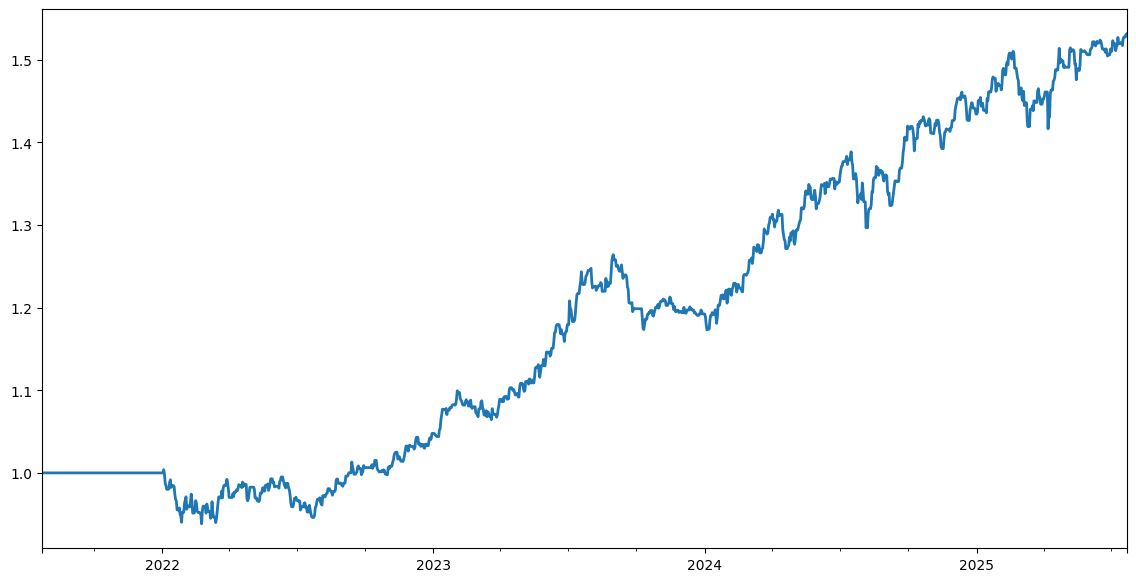

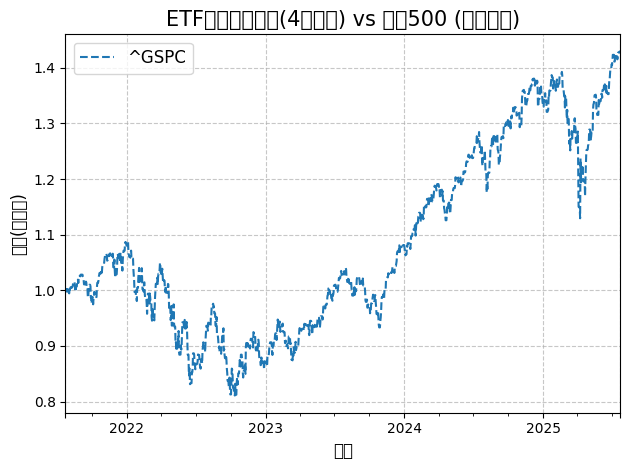

In [92]:
# 导入所需库
import yfinance as yf
import akshare as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 设置回测日期范围
end_date = datetime(2025, 7, 22)
start_date = end_date - timedelta(days=4*365)

# ================== 数据获取部分 ==================

# 获取国际ETF数据 (yfinance) - 加入SPY(标普500ETF)
intl_etfs = {
    'QQQ': '纳斯达克ETF',
    # 'SOYB': '大豆ETF',
    # 'GLD': '黄金ETF',
    # "BTC-USD":"Bitcoin",
    # 'SHY': 'usbond-ETF',
    'SPY': '标普500ETF'  # 新增SPY
}

intl_data = {}
for ticker, name in intl_etfs.items():
    print(f"获取{ticker}数据...")
    df = yf.download(ticker, start=start_date, end=end_date)
    if not df.empty:
        intl_data[ticker] = df[['Close']].rename(columns={'Close': 'close'})

# 获取标普500数据作为基准
print("获取标普500指数数据...")
sp500 = yf.download('^GSPC', start=start_date, end=end_date)[['Close']].rename(columns={'Close': 'close'})

# 获取中国ETF数据 (AKShare)
def fetch_etf_data_ak(symbol, start_date, end_date):
    """通过AKShare获取ETF数据"""
    try:
        df = ak.fund_etf_hist_em(symbol=symbol, period="daily", 
                                start_date=start_date.strftime("%Y%m%d"), 
                                end_date=end_date.strftime("%Y%m%d"), 
                                adjust="hfq")
        df = df.rename(columns={'日期':'date', '收盘':'close'})
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        return df[['close']]
    except Exception as e:
        print(f"获取{symbol}数据失败: {e}")
        return None

# 中国ETF列表
china_etfs = {
    # '159806': '新能源车etf',
    '513030': '德国etf',
    # '159980': '有色金属etf',
    # '513010': '恒生科技',
    # '159740': '恒生科技2',
    # '513520': '日本etf',
    # '159819':'人工智能etf',
    # '159892': '恒生医药',
    '159934': '黄金etf',
    '159985': '豆粕etf',
    '510880': '红利ETF',
    # '513120': '创新药',
    # '516780': '稀土',
    # '588080': '科创50',
    '511010': '上证5年期国债ETF'
}

china_data = {}
for code, name in china_etfs.items():
    print(f"获取{name}({code})数据...")
    df = fetch_etf_data_ak(code, start_date, end_date)
    if df is not None and not df.empty:
        china_data[code] = df

# 合并所有ETF数据
all_etfs = {}
for ticker, df in intl_data.items():
    all_etfs[ticker] = df
    
for code, df in china_data.items():
    all_etfs[code] = df

# 确保所有数据都有相同的日期索引
all_dates = pd.date_range(start_date, end_date)
for ticker in all_etfs:
    all_etfs[ticker] = all_etfs[ticker].reindex(all_dates).fillna(method='ffill')

# 标准化标普500数据
sp500 = sp500.reindex(all_dates).fillna(method='ffill')


def quarterly_momentum_backtest(etf_data, start_date, end_date, initial_capital=100000):
    """
    季度动量策略回测
    规则：每季度选择过去表现最好的4只ETF
    """
    # 创建季度末日期序列
    quarters = pd.date_range(start_date, end_date, freq='Q')
    if end_date not in quarters:
        quarters = quarters.append(pd.DatetimeIndex([end_date]))
    
    # 初始化
    portfolio_value = pd.Series(index=pd.date_range(start_date, end_date), dtype=float)
    portfolio_value.iloc[0] = initial_capital
    current_holdings = {}  # {ticker: shares}
    current_cash = initial_capital
    
    quarterly_selections = []
    quarterly_performance = []
    
    for i in range(len(quarters)-1):
        quarter_start = quarters[i]
        quarter_end = quarters[i+1]
        
        # 计算过去一个季度的收益率
        prev_quarter_start = quarter_start - pd.offsets.QuarterEnd()
        returns = {}
        for ticker, df in etf_data.items():
            if prev_quarter_start in df.index and quarter_start in df.index:
                start_price = df.loc[prev_quarter_start, 'close']
                end_price = df.loc[quarter_start, 'close']
                if isinstance(start_price, pd.Series):
                    start_price = start_price.iloc[0]
                if isinstance(end_price, pd.Series):
                    end_price = end_price.iloc[0]
                returns[ticker] = (end_price - start_price) / start_price
        
        # 选择收益率最高的4只ETF（动量策略）
        if len(returns) >= 4:
            valid_returns = {k: v for k, v in returns.items() if not isinstance(v, (pd.Series, pd.DataFrame))}
            # 修改这里：按收益率降序排序，选择前4名
            selected = sorted(valid_returns.items(), key=lambda x: x[1], reverse=True)[:4]
            selected_tickers = [x[0] for x in selected]
            selected_names = [intl_etfs.get(ticker, china_etfs.get(ticker, ticker)) for ticker in selected_tickers]
            quarterly_selections.append((quarter_start, selected_tickers, selected_names, "动量策略"))
        else:
            selected_tickers = []
            quarterly_selections.append((quarter_start, [], ["现金"], "现金"))
        
        # 计算调仓日价格
        rebalance_prices = {}
        for ticker in selected_tickers:
            price = etf_data[ticker].loc[quarter_start, 'close']
            if isinstance(price, pd.Series):
                price = price.iloc[0]
            rebalance_prices[ticker] = price
        
        # 卖出不在新选择中的持仓
        to_sell = set(current_holdings.keys()) - set(selected_tickers)
        for ticker in to_sell:
            if quarter_start in etf_data[ticker].index:
                price = etf_data[ticker].loc[quarter_start, 'close']
                if isinstance(price, pd.Series):
                    price = price.iloc[0]
                current_cash += current_holdings[ticker] * price
                del current_holdings[ticker]
        
        # 计算当前总价值
        total_value = current_cash
        for ticker, shares in current_holdings.items():
            if quarter_start in etf_data[ticker].index:
                price = etf_data[ticker].loc[quarter_start, 'close']
                if isinstance(price, pd.Series):
                    price = price.iloc[0]
                total_value += shares * price
        
        # 买入新增的ETF
        to_buy = set(selected_tickers) - set(current_holdings.keys())
        if to_buy:
            allocation = total_value / len(selected_tickers)  # 每只ETF的目标金额
            
            # 先调整现有持仓
            for ticker in set(current_holdings.keys()) & set(selected_tickers):
                current_value = current_holdings[ticker] * rebalance_prices[ticker]
                delta = allocation - current_value
                if delta > 0:  # 需要买入更多
                    shares_to_buy = delta / rebalance_prices[ticker]
                    current_holdings[ticker] += shares_to_buy
                    current_cash -= shares_to_buy * rebalance_prices[ticker]
                elif delta < 0:  # 需要卖出部分
                    shares_to_sell = -delta / rebalance_prices[ticker]
                    current_holdings[ticker] -= shares_to_sell
                    current_cash += shares_to_sell * rebalance_prices[ticker]
            
            # 再买入新增的ETF
            for ticker in to_buy:
                shares = allocation / rebalance_prices[ticker]
                current_holdings[ticker] = shares
                current_cash -= shares * rebalance_prices[ticker]
        
        # 如果没有新增的ETF，只需再平衡现有持仓
        elif current_holdings:
            allocation = total_value / len(current_holdings)
            
            for ticker in current_holdings:
                current_value = current_holdings[ticker] * rebalance_prices[ticker]
                delta = allocation - current_value
                if delta > 0:  # 需要买入更多
                    shares_to_buy = delta / rebalance_prices[ticker]
                    current_holdings[ticker] += shares_to_buy
                    current_cash -= shares_to_buy * rebalance_prices[ticker]
                elif delta < 0:  # 需要卖出部分
                    shares_to_sell = -delta / rebalance_prices[ticker]
                    current_holdings[ticker] -= shares_to_sell
                    current_cash += shares_to_sell * rebalance_prices[ticker]
        
        # 计算本季度每日组合价值
        quarter_values = []
        for date in pd.date_range(quarter_start, quarter_end):
            if date in portfolio_value.index:
                daily_value = current_cash
                for ticker, shares in current_holdings.items():
                    if date in etf_data[ticker].index:
                        price = etf_data[ticker].loc[date, 'close']
                        if isinstance(price, pd.Series):
                            price = price.iloc[0]
                        daily_value += shares * price
                portfolio_value.loc[date] = daily_value
                quarter_values.append(daily_value)
        
        # 计算本季度收益率
        if len(quarter_values) > 1:
            quarter_return = (quarter_values[-1] - quarter_values[0]) / quarter_values[0]
        else:
            quarter_return = 0
        quarterly_performance.append((quarter_start, quarter_return))
    
    portfolio_value = portfolio_value.ffill()
    return portfolio_value, quarterly_selections, quarterly_performance

# 执行动量策略回测
portfolio_value, quarterly_selections, quarterly_performance = quarterly_momentum_backtest(all_etfs, start_date, end_date)

# 计算每日收益率
daily_returns = portfolio_value.pct_change().dropna()

# ================== 绩效计算部分 ==================

def calculate_performance_metrics(portfolio_value, daily_returns, benchmark_returns):
    """
    计算绩效指标
    :param portfolio_value: 组合价值序列
    :param daily_returns: 每日收益率序列
    :param benchmark_returns: 基准收益率序列
    :return: 绩效指标字典
    """
    # 总收益率
    total_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0]) - 1
    
    # 年化收益率
    years = len(portfolio_value) / 252
    annualized_return = (1 + total_return) ** (1/years) - 1
    
    # 年化波动率
    annualized_volatility = daily_returns.std() * np.sqrt(252)
    
    # 夏普比率(假设无风险利率3%)
    risk_free_rate = 0.03
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    
    # 最大回撤
    cumulative_returns = (1 + daily_returns).cumprod()
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    
    # 确保日期对齐
    aligned_returns, aligned_benchmark = daily_returns.align(benchmark_returns, join='inner')
    aligned_returns_array = aligned_returns.values
    aligned_benchmark_array = aligned_benchmark.values
    
    # 检查并调整数组形状
    if aligned_returns_array.ndim > 1:
        aligned_returns_array = aligned_returns_array.flatten()
    if aligned_benchmark_array.ndim > 1:
        aligned_benchmark_array = aligned_benchmark_array.flatten()
    
    # 计算Beta
    covariance_matrix = np.cov(aligned_returns_array, aligned_benchmark_array)
    covariance = covariance_matrix[0, 1]
    benchmark_variance = np.var(aligned_benchmark_array)
    beta = covariance / benchmark_variance
    
    # 计算Alpha - 确保结果是标量值
    benchmark_annual_return = (1 + aligned_benchmark.mean()) ** 252 - 1
    if isinstance(benchmark_annual_return, pd.Series):
        benchmark_annual_return = benchmark_annual_return.iloc[0]
    alpha = float(annualized_return - (risk_free_rate + beta * (benchmark_annual_return - risk_free_rate)))
    
    # 分年度收益率
    yearly_returns = portfolio_value.resample('Y').last().pct_change()
    yearly_returns.index = yearly_returns.index.year
    yearly_returns = yearly_returns.dropna()
    
    return {
        '总收益率': total_return,
        '年化收益率': annualized_return,
        '年化波动率': annualized_volatility,
        '夏普比率': sharpe_ratio,
        '最大回撤': max_drawdown,
        'Alpha': alpha,
        'Beta': beta,
        '分年度收益率': yearly_returns
    }

# 计算标普500收益率
sp500_returns = sp500['close'].pct_change().dropna()

# 计算绩效指标
metrics = calculate_performance_metrics(portfolio_value, daily_returns, sp500_returns)

# ================== 结果展示部分 ==================

# print("\n季度选择记录:")
# for quarter in quarterly_selections:
#     date = quarter[0].strftime('%Y-%m-%d')
#     tickers = ", ".join(quarter[1])
#     names = ", ".join(quarter[2])
#     print(f"{date}: 选择基金 {tickers} ({names})")

print("\n季度选择记录及收益率:")
for i, quarter in enumerate(quarterly_selections):
    date = quarter[0].strftime('%Y-%m-%d')
    tickers = ", ".join(quarter[1]) if quarter[1] else "现金"
    names = ", ".join(quarter[2]) if quarter[2] else "现金"
    # 修改这里，因为quarter只有3个元素
    q_return = quarterly_performance[i][1] * 100
    print(f"{date}: 选择基金 {tickers} ({names}) | 季度收益率: {q_return:.2f}%")

print("\n策略绩效指标(5年回测):")
print(f"初始资金: 100,000元")
print(f"最终资金: {portfolio_value.iloc[-1]:,.2f}元")
print(f"总收益率: {metrics['总收益率']*100:.2f}%")
print(f"年化收益率: {metrics['年化收益率']*100:.2f}%")
print(f"年化波动率: {metrics['年化波动率']*100:.2f}%")
print(f"夏普比率: {metrics['夏普比率']:.2f}")
print(f"最大回撤: {metrics['最大回撤']*100:.2f}%")
print(f"Alpha(相对于标普500): {metrics['Alpha']*100:.2f}%")
print(f"Beta(相对于标普500): {metrics['Beta']:.2f}")

print("\n分年度收益率:")
for year, ret in metrics['分年度收益率'].items():
    print(f"{year}: {ret*100:.2f}%")

# 绘制组合价值曲线
plt.figure(figsize=(14, 7))
(portfolio_value / 100000).plot(label='策略净值(10万初始)', linewidth=2)

# 绘制标普500作为比较
(sp500['close'] / sp500['close'].iloc[0]).plot(label='标普500', linestyle='--')

plt.title('ETF季度反转策略(4只基金) vs 标普500 (标准化后)', fontsize=15)
plt.xlabel('日期', fontsize=12)
plt.ylabel('净值(标准化)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

获取QQQ数据...
获取SPY数据...
获取标普500指数数据...
获取有色金属etf(159980)数据...


获取恒生科技(513010)数据...
获取恒生医药(159892)数据...
获取黄金etf(159934)数据...
获取豆粕etf(159985)数据...
获取红利ETF(510880)数据...
获取稀土(516780)数据...

季度选择记录及收益率:
2021-09-30: 现金 | 选择: 现金 (现金) | 季度收益率: 0.00%
2021-12-31: 1234名(上季度盈利) | 选择: 513010, 510880, 159985, 159934 (恒生科技, 红利ETF, 豆粕etf, 黄金etf) | 季度收益率: 5.08%
2022-03-31: 1234名(上季度盈利) | 选择: 159892, 513010, 516780, QQQ (恒生医药, 恒生科技, 稀土, 纳斯达克ETF) | 季度收益率: 3.17%
2022-06-30: 1234名(上季度盈利) | 选择: QQQ, 159980, SPY, 159985 (纳斯达克ETF, 有色金属etf, 标普500ETF, 豆粕etf) | 季度收益率: 1.06%
2022-09-30: 1234名(上季度盈利) | 选择: 513010, 159892, 516780, SPY (恒生科技, 恒生医药, 稀土, 标普500ETF) | 季度收益率: 14.20%
2022-12-31: 1234名(上季度盈利) | 选择: 510880, 516780, QQQ, 159934 (红利ETF, 稀土, 纳斯达克ETF, 黄金etf) | 季度收益率: 9.17%
2023-03-31: 1234名(上季度盈利) | 选择: 159985, 159892, 159980, 513010 (豆粕etf, 恒生医药, 有色金属etf, 恒生科技) | 季度收益率: -2.90%
2023-06-30: 234名+最后1名(上季度亏损) | 选择: 513010, 516780, 159980, QQQ (恒生科技, 稀土, 有色金属etf, 纳斯达克ETF) | 季度收益率: -3.25%
2023-09-30: 234名+最后1名(上季度亏损) | 选择: SPY, QQQ, 513010, 159985 (标普500ETF, 纳斯达克ETF, 恒生科技, 豆粕etf

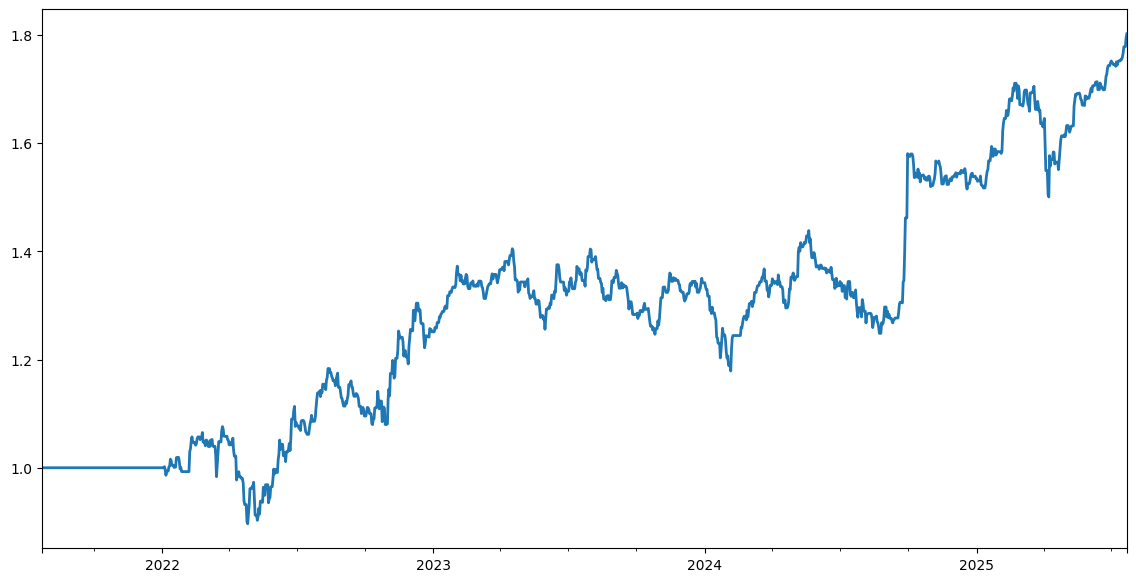

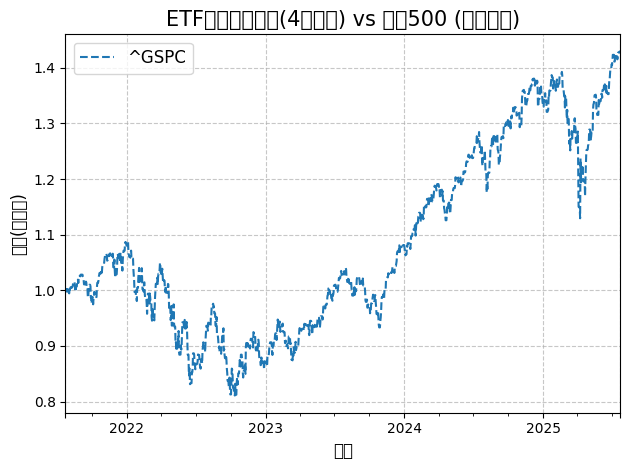

In [94]:
# 导入所需库
import yfinance as yf
import akshare as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 设置回测日期范围
end_date = datetime(2025, 7, 22)
start_date = end_date - timedelta(days=4*365)

# ================== 数据获取部分 ==================

# 获取国际ETF数据 (yfinance) - 加入SPY(标普500ETF)
intl_etfs = {
    'QQQ': '纳斯达克ETF',
    # 'SOYB': '大豆ETF',
    # 'GLD': '黄金ETF',
    # "BTC-USD":"Bitcoin",
    # 'SHY': 'usbond-ETF',
    'SPY': '标普500ETF'  # 新增SPY
}

intl_data = {}
for ticker, name in intl_etfs.items():
    print(f"获取{ticker}数据...")
    df = yf.download(ticker, start=start_date, end=end_date)
    if not df.empty:
        intl_data[ticker] = df[['Close']].rename(columns={'Close': 'close'})

# 获取标普500数据作为基准
print("获取标普500指数数据...")
sp500 = yf.download('^GSPC', start=start_date, end=end_date)[['Close']].rename(columns={'Close': 'close'})

# 获取中国ETF数据 (AKShare)
def fetch_etf_data_ak(symbol, start_date, end_date):
    """通过AKShare获取ETF数据"""
    try:
        df = ak.fund_etf_hist_em(symbol=symbol, period="daily", 
                                start_date=start_date.strftime("%Y%m%d"), 
                                end_date=end_date.strftime("%Y%m%d"), 
                                adjust="hfq")
        df = df.rename(columns={'日期':'date', '收盘':'close'})
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        return df[['close']]
    except Exception as e:
        print(f"获取{symbol}数据失败: {e}")
        return None

# 中国ETF列表
china_etfs = {
    # '159806': '新能源车etf',
    # '513030': '德国etf',
    '159980': '有色金属etf',
    '513010': '恒生科技',
    # '159740': '恒生科技2',
    # '513520': '日本etf',
    # '159819':'人工智能etf',
    '159892': '恒生医药',
    '159934': '黄金etf',
    '159985': '豆粕etf',
    '510880': '红利ETF',
    # '513120': '创新药',
    '516780': '稀土',
    # '588080': '科创50',
    # '511010': '上证5年期国债ETF'
}

china_data = {}
for code, name in china_etfs.items():
    print(f"获取{name}({code})数据...")
    df = fetch_etf_data_ak(code, start_date, end_date)
    if df is not None and not df.empty:
        china_data[code] = df

# 合并所有ETF数据
all_etfs = {}
for ticker, df in intl_data.items():
    all_etfs[ticker] = df
    
for code, df in china_data.items():
    all_etfs[code] = df

# 确保所有数据都有相同的日期索引
all_dates = pd.date_range(start_date, end_date)
for ticker in all_etfs:
    all_etfs[ticker] = all_etfs[ticker].reindex(all_dates).fillna(method='ffill')

# 标准化标普500数据
sp500 = sp500.reindex(all_dates).fillna(method='ffill')


def quarterly_rotation_backtest(etf_data, start_date, end_date, initial_capital=100000):
    """
    季度再平衡策略回测
    新规则：如果上季度为负收益，则选取排名1-3名和最后一名，否则选1-4名
    """
    # 创建季度末日期序列
    quarters = pd.date_range(start_date, end_date, freq='Q')
    if end_date not in quarters:
        quarters = quarters.append(pd.DatetimeIndex([end_date]))
    
    # 初始化
    portfolio_value = pd.Series(index=pd.date_range(start_date, end_date), dtype=float)
    portfolio_value.iloc[0] = initial_capital
    current_holdings = {}  # {ticker: shares}
    current_cash = initial_capital
    last_quarter_return = 0  # 记录上季度收益率
    
    quarterly_selections = []
    quarterly_performance = []
    
    for i in range(len(quarters)-1):
        quarter_start = quarters[i]
        quarter_end = quarters[i+1]
        
        # 计算过去一个季度的收益率
        prev_quarter_start = quarter_start - pd.offsets.QuarterEnd()
        returns = {}
        for ticker, df in etf_data.items():
            if prev_quarter_start in df.index and quarter_start in df.index:
                start_price = df.loc[prev_quarter_start, 'close']
                end_price = df.loc[quarter_start, 'close']
                if isinstance(start_price, pd.Series):
                    start_price = start_price.iloc[0]
                if isinstance(end_price, pd.Series):
                    end_price = end_price.iloc[0]
                returns[ticker] = (end_price - start_price) / start_price
        
        # 动态选择ETF：根据上季度收益决定选择范围
        if len(returns) >= 4:
            valid_returns = {k: v for k, v in returns.items() if not isinstance(v, (pd.Series, pd.DataFrame))}
            sorted_returns = sorted(valid_returns.items(), key=lambda x: x[1])  # 升序排序
            
            # 根据上季度收益决定选择范围
            if last_quarter_return < 0:  # 上季度亏损，选择1-3名和最后一名
                selected = sorted_returns[1:4] + [sorted_returns[-1]]  # 前3名+最后1名
                selection_type = "234名+最后1名(上季度亏损)"
            else:  # 上季度盈利，选择1-4名
                selected = sorted_returns[:4]
                selection_type = "1234名(上季度盈利)"
                
            selected_tickers = [x[0] for x in selected]
            selected_names = [intl_etfs.get(ticker, china_etfs.get(ticker, ticker)) for ticker in selected_tickers]
            quarterly_selections.append((quarter_start, selected_tickers, selected_names, selection_type))
        elif len(returns) >= 4:  # 回退到原始逻辑
            valid_returns = {k: v for k, v in returns.items() if not isinstance(v, (pd.Series, pd.DataFrame))}
            selected = sorted(valid_returns.items(), key=lambda x: x[1])[:4]
            selected_tickers = [x[0] for x in selected]
            selected_names = [intl_etfs.get(ticker, china_etfs.get(ticker, ticker)) for ticker in selected_tickers]
            quarterly_selections.append((quarter_start, selected_tickers, selected_names, "1234名(默认)"))
        else:
            selected_tickers = []
            quarterly_selections.append((quarter_start, [], ["现金"], "现金"))
        
        # 计算调仓日价格（确保获取标量值）
        rebalance_prices = {}
        for ticker in selected_tickers:
            price = etf_data[ticker].loc[quarter_start, 'close']
            if isinstance(price, pd.Series):
                price = price.iloc[0]
            rebalance_prices[ticker] = price
        
        # 卖出不在新选择中的持仓
        to_sell = set(current_holdings.keys()) - set(selected_tickers)
        for ticker in to_sell:
            if quarter_start in etf_data[ticker].index:
                price = etf_data[ticker].loc[quarter_start, 'close']
                if isinstance(price, pd.Series):
                    price = price.iloc[0]
                current_cash += current_holdings[ticker] * price
                del current_holdings[ticker]
        
        # 计算当前总价值
        total_value = current_cash
        for ticker, shares in current_holdings.items():
            if quarter_start in etf_data[ticker].index:
                price = etf_data[ticker].loc[quarter_start, 'close']
                if isinstance(price, pd.Series):
                    price = price.iloc[0]
                total_value += shares * price
        
        # 买入新增的ETF
        to_buy = set(selected_tickers) - set(current_holdings.keys())
        if to_buy:
            allocation = total_value / len(selected_tickers)  # 每只ETF的目标金额
            
            # 先调整现有持仓
            for ticker in set(current_holdings.keys()) & set(selected_tickers):
                current_value = current_holdings[ticker] * rebalance_prices[ticker]
                delta = allocation - current_value
                if delta > 0:  # 需要买入更多
                    shares_to_buy = delta / rebalance_prices[ticker]
                    current_holdings[ticker] += shares_to_buy
                    current_cash -= shares_to_buy * rebalance_prices[ticker]
                elif delta < 0:  # 需要卖出部分
                    shares_to_sell = -delta / rebalance_prices[ticker]
                    current_holdings[ticker] -= shares_to_sell
                    current_cash += shares_to_sell * rebalance_prices[ticker]
            
            # 再买入新增的ETF
            for ticker in to_buy:
                shares = allocation / rebalance_prices[ticker]
                current_holdings[ticker] = shares
                current_cash -= shares * rebalance_prices[ticker]
        
        # 如果没有新增的ETF，只需再平衡现有持仓
        elif current_holdings:
            allocation = total_value / len(current_holdings)
            
            for ticker in current_holdings:
                current_value = current_holdings[ticker] * rebalance_prices[ticker]
                delta = allocation - current_value
                if delta > 0:  # 需要买入更多
                    shares_to_buy = delta / rebalance_prices[ticker]
                    current_holdings[ticker] += shares_to_buy
                    current_cash -= shares_to_buy * rebalance_prices[ticker]
                elif delta < 0:  # 需要卖出部分
                    shares_to_sell = -delta / rebalance_prices[ticker]
                    current_holdings[ticker] -= shares_to_sell
                    current_cash += shares_to_sell * rebalance_prices[ticker]
        
        # 计算本季度每日组合价值
        quarter_values = []
        for date in pd.date_range(quarter_start, quarter_end):
            if date in portfolio_value.index:
                daily_value = current_cash
                for ticker, shares in current_holdings.items():
                    if date in etf_data[ticker].index:
                        price = etf_data[ticker].loc[date, 'close']
                        if isinstance(price, pd.Series):
                            price = price.iloc[0]
                        daily_value += shares * price
                portfolio_value.loc[date] = daily_value
                quarter_values.append(daily_value)
        
        # 计算本季度收益率并记录
        if len(quarter_values) > 1:
            last_quarter_return = (quarter_values[-1] - quarter_values[0]) / quarter_values[0]
        else:
            last_quarter_return = 0
        quarterly_performance.append((quarter_start, last_quarter_return))
    
    portfolio_value = portfolio_value.ffill()
    return portfolio_value, quarterly_selections, quarterly_performance

# 执行回测
portfolio_value, quarterly_selections, quarterly_performance = quarterly_rotation_backtest(all_etfs, start_date, end_date)

# 计算每日收益率
daily_returns = portfolio_value.pct_change().dropna()

# ================== 绩效计算部分 ==================

def calculate_performance_metrics(portfolio_value, daily_returns, benchmark_returns):
    """
    计算绩效指标
    :param portfolio_value: 组合价值序列
    :param daily_returns: 每日收益率序列
    :param benchmark_returns: 基准收益率序列
    :return: 绩效指标字典
    """
    # 总收益率
    total_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0]) - 1
    
    # 年化收益率
    years = len(portfolio_value) / 252
    annualized_return = (1 + total_return) ** (1/years) - 1
    
    # 年化波动率
    annualized_volatility = daily_returns.std() * np.sqrt(252)
    
    # 夏普比率(假设无风险利率3%)
    risk_free_rate = 0.03
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    
    # 最大回撤
    cumulative_returns = (1 + daily_returns).cumprod()
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    
    # 确保日期对齐
    aligned_returns, aligned_benchmark = daily_returns.align(benchmark_returns, join='inner')
    aligned_returns_array = aligned_returns.values
    aligned_benchmark_array = aligned_benchmark.values
    
    # 检查并调整数组形状
    if aligned_returns_array.ndim > 1:
        aligned_returns_array = aligned_returns_array.flatten()
    if aligned_benchmark_array.ndim > 1:
        aligned_benchmark_array = aligned_benchmark_array.flatten()
    
    # 计算Beta
    covariance_matrix = np.cov(aligned_returns_array, aligned_benchmark_array)
    covariance = covariance_matrix[0, 1]
    benchmark_variance = np.var(aligned_benchmark_array)
    beta = covariance / benchmark_variance
    
    # 计算Alpha - 确保结果是标量值
    benchmark_annual_return = (1 + aligned_benchmark.mean()) ** 252 - 1
    if isinstance(benchmark_annual_return, pd.Series):
        benchmark_annual_return = benchmark_annual_return.iloc[0]
    alpha = float(annualized_return - (risk_free_rate + beta * (benchmark_annual_return - risk_free_rate)))
    
    # 分年度收益率
    yearly_returns = portfolio_value.resample('Y').last().pct_change()
    yearly_returns.index = yearly_returns.index.year
    yearly_returns = yearly_returns.dropna()
    
    return {
        '总收益率': total_return,
        '年化收益率': annualized_return,
        '年化波动率': annualized_volatility,
        '夏普比率': sharpe_ratio,
        '最大回撤': max_drawdown,
        'Alpha': alpha,
        'Beta': beta,
        '分年度收益率': yearly_returns
    }

# 计算标普500收益率
sp500_returns = sp500['close'].pct_change().dropna()

# 计算绩效指标
metrics = calculate_performance_metrics(portfolio_value, daily_returns, sp500_returns)

# ================== 结果展示部分 ==================

# print("\n季度选择记录:")
# for quarter in quarterly_selections:
#     date = quarter[0].strftime('%Y-%m-%d')
#     tickers = ", ".join(quarter[1])
#     names = ", ".join(quarter[2])
#     print(f"{date}: 选择基金 {tickers} ({names})")

print("\n季度选择记录及收益率:")
for i, quarter in enumerate(quarterly_selections):
    date = quarter[0].strftime('%Y-%m-%d')
    tickers = ", ".join(quarter[1]) if quarter[1] else "现金"
    names = ", ".join(quarter[2]) if quarter[2] else "现金"
    strategy = quarter[3]  # 策略类型
    q_return = quarterly_performance[i][1] * 100
    print(f"{date}: {strategy} | 选择: {tickers} ({names}) | 季度收益率: {q_return:.2f}%")

print("\n策略绩效指标(5年回测):")
print(f"初始资金: 100,000元")
print(f"最终资金: {portfolio_value.iloc[-1]:,.2f}元")
print(f"总收益率: {metrics['总收益率']*100:.2f}%")
print(f"年化收益率: {metrics['年化收益率']*100:.2f}%")
print(f"年化波动率: {metrics['年化波动率']*100:.2f}%")
print(f"夏普比率: {metrics['夏普比率']:.2f}")
print(f"最大回撤: {metrics['最大回撤']*100:.2f}%")
print(f"Alpha(相对于标普500): {metrics['Alpha']*100:.2f}%")
print(f"Beta(相对于标普500): {metrics['Beta']:.2f}")

print("\n分年度收益率:")
for year, ret in metrics['分年度收益率'].items():
    print(f"{year}: {ret*100:.2f}%")

# 绘制组合价值曲线
plt.figure(figsize=(14, 7))
(portfolio_value / 100000).plot(label='策略净值(10万初始)', linewidth=2)

# 绘制标普500作为比较
(sp500['close'] / sp500['close'].iloc[0]).plot(label='标普500', linestyle='--')

plt.title('ETF季度反转策略(4只基金) vs 标普500 (标准化后)', fontsize=15)
plt.xlabel('日期', fontsize=12)
plt.ylabel('净值(标准化)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

获取QQQ数据...
获取SPY数据...
获取标普500指数数据...
获取有色金属etf(159980)数据...


获取恒生科技(513010)数据...
获取恒生医药(159892)数据...
获取黄金etf(159934)数据...
获取豆粕etf(159985)数据...
获取红利ETF(510880)数据...
获取稀土(516780)数据...

季度选择记录及收益率:
2018-09-30: 选择基金 现金 (现金) | 季度收益率: 0.00%
2018-12-31: 选择基金 QQQ, SPY, 510880, 159934 (纳斯达克ETF, 标普500ETF, 红利ETF, 黄金etf) | 季度收益率: 10.65%
2019-03-31: 选择基金 159934, SPY, 510880, QQQ (黄金etf, 标普500ETF, 红利ETF, 纳斯达克ETF) | 季度收益率: 4.04%
2019-06-30: 选择基金 510880, QQQ, SPY, 159934 (红利ETF, 纳斯达克ETF, 标普500ETF, 黄金etf) | 季度收益率: 2.86%
2019-09-30: 选择基金 510880, QQQ, SPY, 159934 (红利ETF, 纳斯达克ETF, 标普500ETF, 黄金etf) | 季度收益率: 6.35%
2019-12-31: 选择基金 159934, 510880, SPY, QQQ (黄金etf, 红利ETF, 标普500ETF, 纳斯达克ETF) | 季度收益率: -8.42%
2020-03-31: 选择基金 SPY, 159980, QQQ, 510880 (标普500ETF, 有色金属etf, 纳斯达克ETF, 红利ETF) | 季度收益率: 17.53%
2020-06-30: 选择基金 159985, 510880, 159934, 159980 (豆粕etf, 红利ETF, 黄金etf, 有色金属etf) | 季度收益率: 6.52%
2020-09-30: 选择基金 159934, 159980, 510880, SPY (黄金etf, 有色金属etf, 红利ETF, 标普500ETF) | 季度收益率: 5.28%
2020-12-31: 选择基金 159934, 510880, 159980, SPY (黄金etf, 红利ETF, 有色金属etf, 标普500ETF) | 季度收益率:

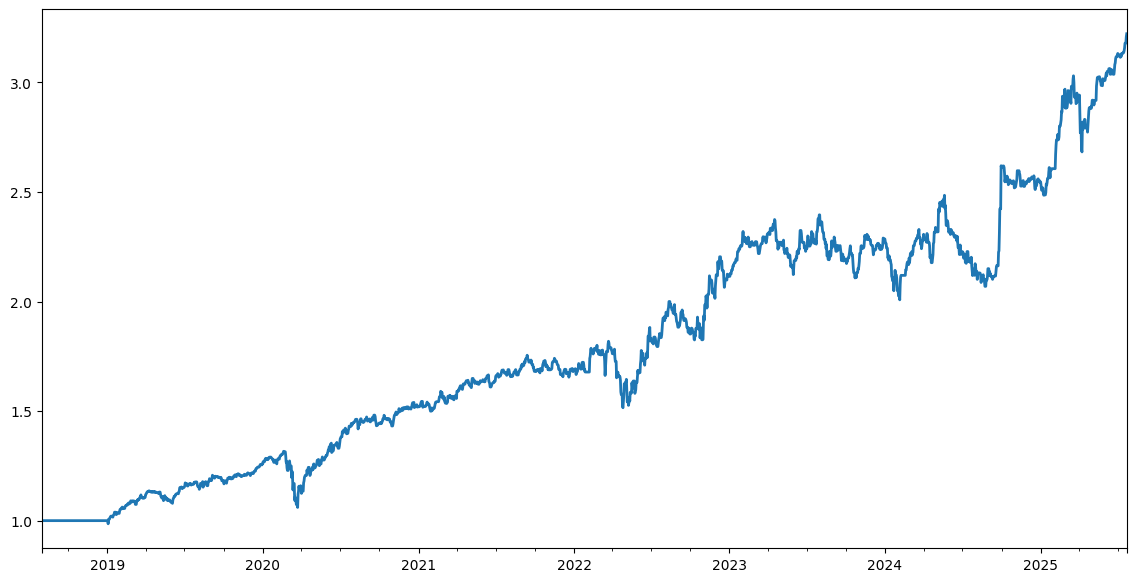

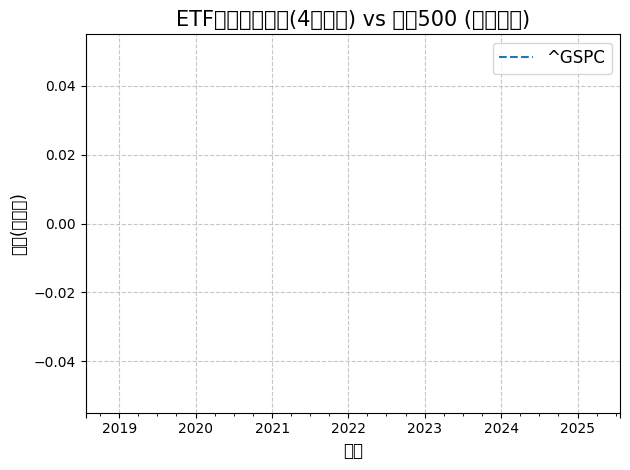

In [119]:
# 导入所需库
import yfinance as yf
import akshare as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 设置回测日期范围
end_date = datetime(2025, 7, 22)
start_date = end_date - timedelta(days=7*365)

# ================== 数据获取部分 ==================

# 获取国际ETF数据 (yfinance) - 加入SPY(标普500ETF)
intl_etfs = {
    'QQQ': '纳斯达克ETF',
    # 'SOYB': '大豆ETF',
    # 'GLD': '黄金ETF',
    # "BTC-USD":"Bitcoin",
    # 'SHY': 'usbond-ETF',
    'SPY': '标普500ETF'  # 新增SPY
}

# 获取国际ETF数据 (yfinance) - 加入SPY(标普500ETF)
intl_data = {}
for ticker, name in intl_etfs.items():
    print(f"获取{ticker}数据...")
    # 增加一周缓冲期
    adjusted_start_date = start_date + timedelta(days=7)
    df = yf.download(ticker, start=adjusted_start_date, end=end_date)
    if not df.empty:
        intl_data[ticker] = df[['Close']].rename(columns={'Close': 'close'})

# 获取标普500数据作为基准
print("获取标普500指数数据...")
# 增加一周缓冲期
adjusted_start_date = start_date + timedelta(days=7)
sp500 = yf.download('^GSPC', start=adjusted_start_date, end=end_date)[['Close']].rename(columns={'Close': 'close'})

# 获取中国ETF数据 (AKShare)
def fetch_etf_data_ak(symbol, start_date, end_date):
    """通过AKShare获取ETF数据"""
    try:
        # 增加一周缓冲期
        adjusted_start_date = start_date + timedelta(days=7)
        df = ak.fund_etf_hist_em(symbol=symbol, period="daily", 
                                start_date=adjusted_start_date.strftime("%Y%m%d"), 
                                end_date=end_date.strftime("%Y%m%d"), 
                                adjust="hfq")
        df = df.rename(columns={'日期':'date', '收盘':'close'})
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        return df[['close']]
    except Exception as e:
        print(f"获取{symbol}数据失败: {e}")
        return None

# 中国ETF列表
china_etfs = {
    # '159806': '新能源车etf',
    # '513030': '德国etf',
    '159980': '有色金属etf',
    '513010': '恒生科技',
    # '159740': '恒生科技2',
    # '513520': '日本etf',
    # '159819':'人工智能etf',
    '159892': '恒生医药',
    '159934': '黄金etf',
    '159985': '豆粕etf',
    '510880': '红利ETF',
    # '513120': '创新药',
    '516780': '稀土',
    # '588080': '科创50',
    # '511010': '上证5年期国债ETF'
}

china_data = {}
for code, name in china_etfs.items():
    print(f"获取{name}({code})数据...")
    df = fetch_etf_data_ak(code, start_date, end_date)
    if df is not None and not df.empty:
        china_data[code] = df

# 合并所有ETF数据
all_etfs = {}
for ticker, df in intl_data.items():
    all_etfs[ticker] = df
    
for code, df in china_data.items():
    all_etfs[code] = df

# 确保所有数据都有相同的日期索引
all_dates = pd.date_range(start_date, end_date)
for ticker in all_etfs:
    all_etfs[ticker] = all_etfs[ticker].reindex(all_dates).fillna(method='ffill')

# 标准化标普500数据
sp500 = sp500.reindex(all_dates).fillna(method='ffill')


def quarterly_rotation_backtest(etf_data, start_date, end_date, initial_capital=100000):
    """
    季度再平衡策略回测 - 完全避免模糊的真值判断
    """
    # 调整开始日期，去掉第一周数据
    adjusted_start_date = start_date + timedelta(days=7)
    
    # 创建季度末日期序列
    quarters = pd.date_range(adjusted_start_date, end_date, freq='Q')
    if end_date not in quarters:
        quarters = quarters.append(pd.DatetimeIndex([end_date]))
    
    # 初始化
    portfolio_value = pd.Series(index=pd.date_range(adjusted_start_date, end_date), dtype=float)
    portfolio_value.iloc[0] = initial_capital
    current_holdings = {}  # {ticker: shares}
    current_cash = initial_capital
    
    quarterly_selections = []
    quarterly_performance = []
    
    for i in range(len(quarters)-1):
        quarter_start = quarters[i]
        quarter_end = quarters[i+1]
        
        # 计算过去一个季度的收益率
        prev_quarter_start = quarter_start - pd.offsets.QuarterEnd()
        returns = {}
        
        for ticker, df in etf_data.items():
            # 获取价格数据 - 使用显式检查
            try:
                quarter_start_data = df.loc[quarter_start]
                prev_quarter_start_data = df.loc[prev_quarter_start]
                
                # 确保我们获取的是标量值
                quarter_start_close = quarter_start_data['close']
                if isinstance(quarter_start_close, (pd.Series, pd.DataFrame)):
                    quarter_start_close = quarter_start_close.iloc[0]
                
                prev_quarter_start_close = prev_quarter_start_data['close']
                if isinstance(prev_quarter_start_close, (pd.Series, pd.DataFrame)):
                    prev_quarter_start_close = prev_quarter_start_close.iloc[0]
                
                # 显式检查NaN值
                if not np.isnan(quarter_start_close) and not np.isnan(prev_quarter_start_close):
                    returns[ticker] = (quarter_start_close - prev_quarter_start_close) / prev_quarter_start_close
            except (KeyError, AttributeError):
                continue
        
        # 选择收益率最低的4只ETF
        if len(returns) >= 4:
            selected = sorted(returns.items(), key=lambda x: x[1])[:4]
            selected_tickers = [x[0] for x in selected]
            selected_names = [intl_etfs.get(ticker, china_etfs.get(ticker, ticker)) for ticker in selected_tickers]
            quarterly_selections.append((quarter_start, selected_tickers, selected_names))
        else:
            selected_tickers = []
            quarterly_selections.append((quarter_start, [], ["现金"]))
        
        # 计算调仓日价格
        rebalance_prices = {}
        for ticker in selected_tickers:
            try:
                price_data = etf_data[ticker].loc[quarter_start]
                price = price_data['close']
                if isinstance(price, (pd.Series, pd.DataFrame)):
                    price = price.iloc[0]
                if not np.isnan(price):
                    rebalance_prices[ticker] = price
            except (KeyError, AttributeError):
                continue
        
        # 卖出不在新选择中的持仓
        to_sell = set(current_holdings.keys()) - set(selected_tickers)
        for ticker in to_sell:
            try:
                price_data = etf_data[ticker].loc[quarter_start]
                price = price_data['close']
                if isinstance(price, (pd.Series, pd.DataFrame)):
                    price = price.iloc[0]
                if not np.isnan(price):
                    current_cash += current_holdings[ticker] * price
                    del current_holdings[ticker]
            except (KeyError, AttributeError):
                continue
        
        # 计算当前总价值
        total_value = current_cash
        for ticker, shares in current_holdings.items():
            try:
                price_data = etf_data[ticker].loc[quarter_start]
                price = price_data['close']
                if isinstance(price, (pd.Series, pd.DataFrame)):
                    price = price.iloc[0]
                if not np.isnan(price):
                    total_value += shares * price
            except (KeyError, AttributeError):
                continue
        
        # 买入新增的ETF
        to_buy = [t for t in (set(selected_tickers) - set(current_holdings.keys())) 
                 if t in rebalance_prices]
        if to_buy:
            allocation = total_value / len(selected_tickers)
            
            # 调整现有持仓
            for ticker in set(current_holdings.keys()) & set(selected_tickers):
                if ticker in rebalance_prices:
                    current_value = current_holdings[ticker] * rebalance_prices[ticker]
                    delta = allocation - current_value
                    if delta > 0:
                        shares_to_buy = delta / rebalance_prices[ticker]
                        current_holdings[ticker] += shares_to_buy
                        current_cash -= shares_to_buy * rebalance_prices[ticker]
                    elif delta < 0:
                        shares_to_sell = -delta / rebalance_prices[ticker]
                        current_holdings[ticker] -= shares_to_sell
                        current_cash += shares_to_sell * rebalance_prices[ticker]
            
            # 买入新增ETF
            for ticker in to_buy:
                if ticker in rebalance_prices:
                    shares = allocation / rebalance_prices[ticker]
                    current_holdings[ticker] = shares
                    current_cash -= shares * rebalance_prices[ticker]
        
        # 如果没有新增的ETF，只需再平衡现有持仓
        elif current_holdings:
            allocation = total_value / len(current_holdings)
            
            for ticker in current_holdings:
                if ticker in rebalance_prices:
                    current_value = current_holdings[ticker] * rebalance_prices[ticker]
                    delta = allocation - current_value
                    if delta > 0:
                        shares_to_buy = delta / rebalance_prices[ticker]
                        current_holdings[ticker] += shares_to_buy
                        current_cash -= shares_to_buy * rebalance_prices[ticker]
                    elif delta < 0:
                        shares_to_sell = -delta / rebalance_prices[ticker]
                        current_holdings[ticker] -= shares_to_sell
                        current_cash += shares_to_sell * rebalance_prices[ticker]
        
        # 计算本季度每日组合价值
        quarter_values = []
        for date in pd.date_range(quarter_start, quarter_end):
            if date in portfolio_value.index:
                daily_value = current_cash
                for ticker, shares in current_holdings.items():
                    try:
                        price_data = etf_data[ticker].loc[date]
                        price = price_data['close']
                        if isinstance(price, (pd.Series, pd.DataFrame)):
                            price = price.iloc[0]
                        if not np.isnan(price):
                            daily_value += shares * price
                    except (KeyError, AttributeError):
                        continue
                portfolio_value.loc[date] = daily_value
                quarter_values.append(daily_value)
        
        # 计算本季度收益率
        if len(quarter_values) > 1 and quarter_values[0] != 0:
            quarter_return = (quarter_values[-1] - quarter_values[0]) / quarter_values[0]
        else:
            quarter_return = 0
        quarterly_performance.append((quarter_start, quarter_return))
    
    portfolio_value = portfolio_value.ffill()
    return portfolio_value, quarterly_selections, quarterly_performance
    

# 执行回测
portfolio_value, quarterly_selections, quarterly_performance = quarterly_rotation_backtest(all_etfs, start_date, end_date)

# 计算每日收益率
daily_returns = portfolio_value.pct_change().dropna()

# ================== 绩效计算部分 ==================

def calculate_performance_metrics(portfolio_value, daily_returns, benchmark_returns):
    """
    计算绩效指标
    :param portfolio_value: 组合价值序列
    :param daily_returns: 每日收益率序列
    :param benchmark_returns: 基准收益率序列
    :return: 绩效指标字典
    """
    # 总收益率
    total_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0]) - 1
    
    # 年化收益率
    years = len(portfolio_value) / 252
    annualized_return = (1 + total_return) ** (1/years) - 1
    
    # 年化波动率
    annualized_volatility = daily_returns.std() * np.sqrt(252)
    
    # 夏普比率(假设无风险利率3%)
    risk_free_rate = 0.03
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    
    # 最大回撤
    cumulative_returns = (1 + daily_returns).cumprod()
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    
    # 确保日期对齐
    aligned_returns, aligned_benchmark = daily_returns.align(benchmark_returns, join='inner')
    aligned_returns_array = aligned_returns.values
    aligned_benchmark_array = aligned_benchmark.values
    
    # 检查并调整数组形状
    if aligned_returns_array.ndim > 1:
        aligned_returns_array = aligned_returns_array.flatten()
    if aligned_benchmark_array.ndim > 1:
        aligned_benchmark_array = aligned_benchmark_array.flatten()
    
    # 计算Beta
    covariance_matrix = np.cov(aligned_returns_array, aligned_benchmark_array)
    covariance = covariance_matrix[0, 1]
    benchmark_variance = np.var(aligned_benchmark_array)
    beta = covariance / benchmark_variance
    
    # 计算Alpha - 确保结果是标量值
    benchmark_annual_return = (1 + aligned_benchmark.mean()) ** 252 - 1
    if isinstance(benchmark_annual_return, pd.Series):
        benchmark_annual_return = benchmark_annual_return.iloc[0]
    alpha = float(annualized_return - (risk_free_rate + beta * (benchmark_annual_return - risk_free_rate)))
    
    # 分年度收益率
    yearly_returns = portfolio_value.resample('Y').last().pct_change()
    yearly_returns.index = yearly_returns.index.year
    yearly_returns = yearly_returns.dropna()
    
    return {
        '总收益率': total_return,
        '年化收益率': annualized_return,
        '年化波动率': annualized_volatility,
        '夏普比率': sharpe_ratio,
        '最大回撤': max_drawdown,
        'Alpha': alpha,
        'Beta': beta,
        '分年度收益率': yearly_returns
    }

# 计算标普500收益率
sp500_returns = sp500['close'].pct_change().dropna()

# 计算绩效指标
metrics = calculate_performance_metrics(portfolio_value, daily_returns, sp500_returns)

# ================== 结果展示部分 ==================

# print("\n季度选择记录:")
# for quarter in quarterly_selections:
#     date = quarter[0].strftime('%Y-%m-%d')
#     tickers = ", ".join(quarter[1])
#     names = ", ".join(quarter[2])
#     print(f"{date}: 选择基金 {tickers} ({names})")

print("\n季度选择记录及收益率:")
for i, quarter in enumerate(quarterly_selections):
    date = quarter[0].strftime('%Y-%m-%d')
    tickers = ", ".join(quarter[1]) if quarter[1] else "现金"
    names = ", ".join(quarter[2]) if quarter[2] else "现金"
    # 修改这里，因为quarter只有3个元素
    q_return = quarterly_performance[i][1] * 100
    print(f"{date}: 选择基金 {tickers} ({names}) | 季度收益率: {q_return:.2f}%")

print("\n策略绩效指标(5年回测):")
print(f"初始资金: 100,000元")
print(f"最终资金: {portfolio_value.iloc[-1]:,.2f}元")
print(f"总收益率: {metrics['总收益率']*100:.2f}%")
print(f"年化收益率: {metrics['年化收益率']*100:.2f}%")
print(f"年化波动率: {metrics['年化波动率']*100:.2f}%")
print(f"夏普比率: {metrics['夏普比率']:.2f}")
print(f"最大回撤: {metrics['最大回撤']*100:.2f}%")
print(f"Alpha(相对于标普500): {metrics['Alpha']*100:.2f}%")
print(f"Beta(相对于标普500): {metrics['Beta']:.2f}")

print("\n分年度收益率:")
for year, ret in metrics['分年度收益率'].items():
    print(f"{year}: {ret*100:.2f}%")

# 绘制组合价值曲线
plt.figure(figsize=(14, 7))
(portfolio_value / 100000).plot(label='策略净值(10万初始)', linewidth=2)

# 绘制标普500作为比较
(sp500['close'] / sp500['close'].iloc[0]).plot(label='标普500', linestyle='--')

plt.title('ETF季度反转策略(4只基金) vs 标普500 (标准化后)', fontsize=15)
plt.xlabel('日期', fontsize=12)
plt.ylabel('净值(标准化)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

获取QQQ数据...
获取SPY数据...
获取标普500指数数据...
获取有色金属etf(159980)数据...


获取恒生科技(513010)数据...
获取恒生医药(159892)数据...
获取黄金etf(159934)数据...
获取豆粕etf(159985)数据...
获取红利ETF(510880)数据...
获取稀土(516780)数据...

季度选择记录及收益率:
2018-09-30: 选择基金 现金 (现金) | 季度收益率: 0.00%
2018-12-31: 选择基金 SPY, 510880, 159934, QQQ (标普500ETF, 红利ETF, 黄金etf, 纳斯达克ETF) | 季度收益率: 10.65%
2019-03-31: 选择基金 SPY, 510880, QQQ, 159934 (标普500ETF, 红利ETF, 纳斯达克ETF, 黄金etf) | 季度收益率: 4.04%
2019-06-30: 选择基金 QQQ, SPY, 159934, 510880 (纳斯达克ETF, 标普500ETF, 黄金etf, 红利ETF) | 季度收益率: 2.86%
2019-09-30: 选择基金 QQQ, SPY, 159934, 510880 (纳斯达克ETF, 标普500ETF, 黄金etf, 红利ETF) | 季度收益率: 6.35%
2019-12-31: 选择基金 510880, SPY, QQQ, 159934 (红利ETF, 标普500ETF, 纳斯达克ETF, 黄金etf) | 季度收益率: -8.42%
2020-03-31: 选择基金 510880, 159985, 159934, SPY, 159980, QQQ (红利ETF, 豆粕etf, 黄金etf, 标普500ETF, 有色金属etf, 纳斯达克ETF) | 季度收益率: 12.44%
2020-06-30: 选择基金 159980, SPY, QQQ, 159985, 510880, 159934 (有色金属etf, 标普500ETF, 纳斯达克ETF, 豆粕etf, 红利ETF, 黄金etf) | 季度收益率: 7.89%
2020-09-30: 选择基金 SPY, 159985, QQQ, 159934, 159980, 510880 (标普500ETF, 豆粕etf, 纳斯达克ETF, 黄金etf, 有色金属etf, 红利ETF) | 季度收益率: 8.69%

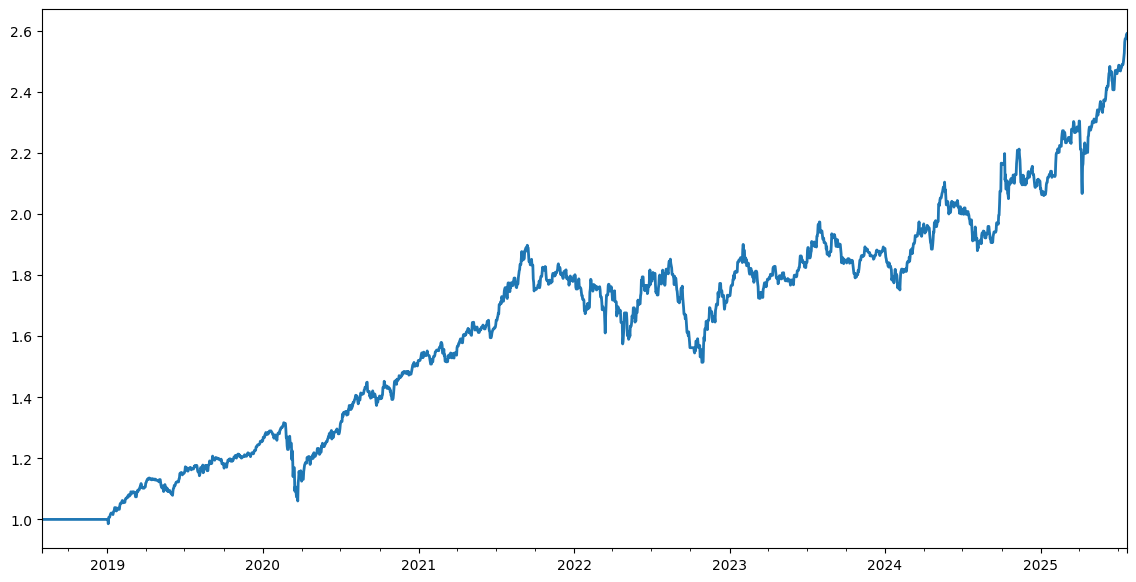

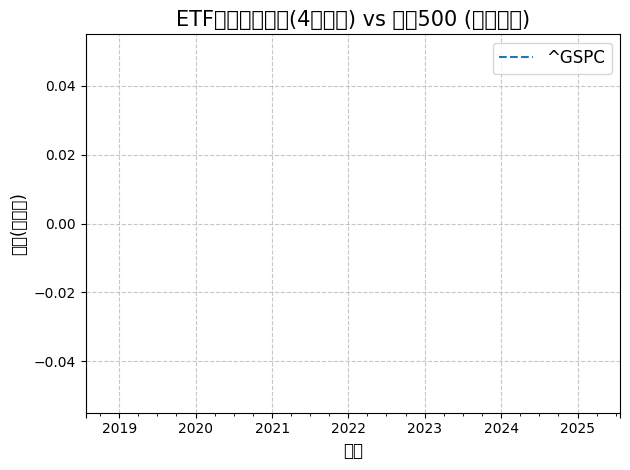

In [121]:
# 导入所需库
import yfinance as yf
import akshare as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 设置回测日期范围
end_date = datetime(2025, 7, 22)
start_date = end_date - timedelta(days=7*365)

# ================== 数据获取部分 ==================

# 获取国际ETF数据 (yfinance) - 加入SPY(标普500ETF)
intl_etfs = {
    'QQQ': '纳斯达克ETF',
    # 'SOYB': '大豆ETF',
    # 'GLD': '黄金ETF',
    # "BTC-USD":"Bitcoin",
    # 'SHY': 'usbond-ETF',
    'SPY': '标普500ETF'  # 新增SPY
}

# 获取国际ETF数据 (yfinance) - 加入SPY(标普500ETF)
intl_data = {}
for ticker, name in intl_etfs.items():
    print(f"获取{ticker}数据...")
    # 增加一周缓冲期
    adjusted_start_date = start_date + timedelta(days=7)
    df = yf.download(ticker, start=adjusted_start_date, end=end_date)
    if not df.empty:
        intl_data[ticker] = df[['Close']].rename(columns={'Close': 'close'})

# 获取标普500数据作为基准
print("获取标普500指数数据...")
# 增加一周缓冲期
adjusted_start_date = start_date + timedelta(days=7)
sp500 = yf.download('^GSPC', start=adjusted_start_date, end=end_date)[['Close']].rename(columns={'Close': 'close'})

# 获取中国ETF数据 (AKShare)
def fetch_etf_data_ak(symbol, start_date, end_date):
    """通过AKShare获取ETF数据"""
    try:
        # 增加一周缓冲期
        adjusted_start_date = start_date + timedelta(days=7)
        df = ak.fund_etf_hist_em(symbol=symbol, period="daily", 
                                start_date=adjusted_start_date.strftime("%Y%m%d"), 
                                end_date=end_date.strftime("%Y%m%d"), 
                                adjust="hfq")
        df = df.rename(columns={'日期':'date', '收盘':'close'})
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        return df[['close']]
    except Exception as e:
        print(f"获取{symbol}数据失败: {e}")
        return None

# 中国ETF列表
china_etfs = {
    # '159806': '新能源车etf',
    # '513030': '德国etf',
    '159980': '有色金属etf',
    '513010': '恒生科技',
    # '159740': '恒生科技2',
    # '513520': '日本etf',
    # '159819':'人工智能etf',
    '159892': '恒生医药',
    '159934': '黄金etf',
    '159985': '豆粕etf',
    '510880': '红利ETF',
    # '513120': '创新药',
    '516780': '稀土',
    # '588080': '科创50',
    # '511010': '上证5年期国债ETF'
}

china_data = {}
for code, name in china_etfs.items():
    print(f"获取{name}({code})数据...")
    df = fetch_etf_data_ak(code, start_date, end_date)
    if df is not None and not df.empty:
        china_data[code] = df

# 合并所有ETF数据
all_etfs = {}
for ticker, df in intl_data.items():
    all_etfs[ticker] = df
    
for code, df in china_data.items():
    all_etfs[code] = df

# 确保所有数据都有相同的日期索引
all_dates = pd.date_range(start_date, end_date)
for ticker in all_etfs:
    all_etfs[ticker] = all_etfs[ticker].reindex(all_dates).fillna(method='ffill')

# 标准化标普500数据
sp500 = sp500.reindex(all_dates).fillna(method='ffill')


def quarterly_rotation_backtest(etf_data, start_date, end_date, initial_capital=100000):
    """
    季度再平衡策略回测 - 完全避免模糊的真值判断
    """
    # 调整开始日期，去掉第一周数据
    adjusted_start_date = start_date + timedelta(days=7)
    
    # 创建季度末日期序列
    quarters = pd.date_range(adjusted_start_date, end_date, freq='Q')
    if end_date not in quarters:
        quarters = quarters.append(pd.DatetimeIndex([end_date]))
    
    # 初始化
    portfolio_value = pd.Series(index=pd.date_range(adjusted_start_date, end_date), dtype=float)
    portfolio_value.iloc[0] = initial_capital
    current_holdings = {}  # {ticker: shares}
    current_cash = initial_capital
    
    quarterly_selections = []
    quarterly_performance = []
    
    for i in range(len(quarters)-1):
        quarter_start = quarters[i]
        quarter_end = quarters[i+1]
        
        # 计算过去一个季度的收益率
        prev_quarter_start = quarter_start - pd.offsets.QuarterEnd()
        returns = {}
        
        for ticker, df in etf_data.items():
            # 获取价格数据 - 使用显式检查
            try:
                quarter_start_data = df.loc[quarter_start]
                prev_quarter_start_data = df.loc[prev_quarter_start]
                
                # 确保我们获取的是标量值
                quarter_start_close = quarter_start_data['close']
                if isinstance(quarter_start_close, (pd.Series, pd.DataFrame)):
                    quarter_start_close = quarter_start_close.iloc[0]
                
                prev_quarter_start_close = prev_quarter_start_data['close']
                if isinstance(prev_quarter_start_close, (pd.Series, pd.DataFrame)):
                    prev_quarter_start_close = prev_quarter_start_close.iloc[0]
                
                # 显式检查NaN值
                if not np.isnan(quarter_start_close) and not np.isnan(prev_quarter_start_close):
                    returns[ticker] = (quarter_start_close - prev_quarter_start_close) / prev_quarter_start_close
            except (KeyError, AttributeError):
                continue
        
        # 选择收益率最低的4只ETF
        # if len(returns) >= 4:
        #     selected = sorted(returns.items(), key=lambda x: x[1])[:4]
        #     selected_tickers = [x[0] for x in selected]
        #     selected_names = [intl_etfs.get(ticker, china_etfs.get(ticker, ticker)) for ticker in selected_tickers]
        #     quarterly_selections.append((quarter_start, selected_tickers, selected_names))
        # else:
        #     selected_tickers = []
        #     quarterly_selections.append((quarter_start, [], ["现金"]))
        
        # 按收益率排序
        sorted_returns = sorted(returns.items(), key=lambda x: x[1])
        
        # 选择前3名和倒数3名
        top3 = sorted_returns[-3:]  # 收益率最高的3个
        bottom3 = sorted_returns[:3]  # 收益率最低的3个
        
        # 分配权重
        weights = {}
        
        # 前3名各25%
        for ticker, ret in top3:
            weights[ticker] = 0.25
            
        # 倒数3名按9:8:8分配剩余25%
        bottom_weights = [0.09, 0.08, 0.08]  # 总和0.25
        for (ticker, ret), weight in zip(bottom3, bottom_weights):
            weights[ticker] = weight
        
        selected_tickers = list(weights.keys())
        selected_names = [intl_etfs.get(ticker, china_etfs.get(ticker, ticker)) 
                         for ticker in selected_tickers]
        quarterly_selections.append((quarter_start, selected_tickers, selected_names))
        
        # 计算调仓日价格
        rebalance_prices = {}
        for ticker in selected_tickers:
            try:
                price_data = etf_data[ticker].loc[quarter_start]
                price = price_data['close']
                if isinstance(price, (pd.Series, pd.DataFrame)):
                    price = price.iloc[0]
                if not np.isnan(price):
                    rebalance_prices[ticker] = price
            except (KeyError, AttributeError):
                continue
        
        # 卖出不在新选择中的持仓
        to_sell = set(current_holdings.keys()) - set(selected_tickers)
        for ticker in to_sell:
            try:
                price_data = etf_data[ticker].loc[quarter_start]
                price = price_data['close']
                if isinstance(price, (pd.Series, pd.DataFrame)):
                    price = price.iloc[0]
                if not np.isnan(price):
                    current_cash += current_holdings[ticker] * price
                    del current_holdings[ticker]
            except (KeyError, AttributeError):
                continue
        
        # 计算当前总价值
        total_value = current_cash
        for ticker, shares in current_holdings.items():
            try:
                price_data = etf_data[ticker].loc[quarter_start]
                price = price_data['close']
                if isinstance(price, (pd.Series, pd.DataFrame)):
                    price = price.iloc[0]
                if not np.isnan(price):
                    total_value += shares * price
            except (KeyError, AttributeError):
                continue

        # 调整持仓到目标权重
        # current_holdings = {}  # 清空现有持仓，重新分配
        
        # for ticker in selected_tickers:
        #     if ticker in rebalance_prices:
        #         target_value = total_value * weights[ticker]
        #         shares = target_value / rebalance_prices[ticker]
        #         current_holdings[ticker] = shares
        #         current_cash -= target_value
        
        # 买入新增的ETF
        to_buy = [t for t in (set(selected_tickers) - set(current_holdings.keys())) 
                 if t in rebalance_prices]
        if to_buy:
            allocation = total_value / len(selected_tickers)
            
            # 调整现有持仓
            for ticker in set(current_holdings.keys()) & set(selected_tickers):
                if ticker in rebalance_prices:
                    current_value = current_holdings[ticker] * rebalance_prices[ticker]
                    delta = allocation - current_value
                    if delta > 0:
                        shares_to_buy = delta / rebalance_prices[ticker]
                        current_holdings[ticker] += shares_to_buy
                        current_cash -= shares_to_buy * rebalance_prices[ticker]
                    elif delta < 0:
                        shares_to_sell = -delta / rebalance_prices[ticker]
                        current_holdings[ticker] -= shares_to_sell
                        current_cash += shares_to_sell * rebalance_prices[ticker]
            
            # 买入新增ETF
            for ticker in to_buy:
                if ticker in rebalance_prices:
                    shares = allocation / rebalance_prices[ticker]
                    current_holdings[ticker] = shares
                    current_cash -= shares * rebalance_prices[ticker]
        
        # 如果没有新增的ETF，只需再平衡现有持仓
        elif current_holdings:
            allocation = total_value / len(current_holdings)
            
            for ticker in current_holdings:
                if ticker in rebalance_prices:
                    current_value = current_holdings[ticker] * rebalance_prices[ticker]
                    delta = allocation - current_value
                    if delta > 0:
                        shares_to_buy = delta / rebalance_prices[ticker]
                        current_holdings[ticker] += shares_to_buy
                        current_cash -= shares_to_buy * rebalance_prices[ticker]
                    elif delta < 0:
                        shares_to_sell = -delta / rebalance_prices[ticker]
                        current_holdings[ticker] -= shares_to_sell
                        current_cash += shares_to_sell * rebalance_prices[ticker]
        
        # 计算本季度每日组合价值
        quarter_values = []
        for date in pd.date_range(quarter_start, quarter_end):
            if date in portfolio_value.index:
                daily_value = current_cash
                for ticker, shares in current_holdings.items():
                    try:
                        price_data = etf_data[ticker].loc[date]
                        price = price_data['close']
                        if isinstance(price, (pd.Series, pd.DataFrame)):
                            price = price.iloc[0]
                        if not np.isnan(price):
                            daily_value += shares * price
                    except (KeyError, AttributeError):
                        continue
                portfolio_value.loc[date] = daily_value
                quarter_values.append(daily_value)
        
        # 计算本季度收益率
        if len(quarter_values) > 1 and quarter_values[0] != 0:
            quarter_return = (quarter_values[-1] - quarter_values[0]) / quarter_values[0]
        else:
            quarter_return = 0
        quarterly_performance.append((quarter_start, quarter_return))
    
    portfolio_value = portfolio_value.ffill()
    return portfolio_value, quarterly_selections, quarterly_performance
    

# 执行回测
portfolio_value, quarterly_selections, quarterly_performance = quarterly_rotation_backtest(all_etfs, start_date, end_date)

# 计算每日收益率
daily_returns = portfolio_value.pct_change().dropna()

# ================== 绩效计算部分 ==================

def calculate_performance_metrics(portfolio_value, daily_returns, benchmark_returns):
    """
    计算绩效指标
    :param portfolio_value: 组合价值序列
    :param daily_returns: 每日收益率序列
    :param benchmark_returns: 基准收益率序列
    :return: 绩效指标字典
    """
    # 总收益率
    total_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0]) - 1
    
    # 年化收益率
    years = len(portfolio_value) / 252
    annualized_return = (1 + total_return) ** (1/years) - 1
    
    # 年化波动率
    annualized_volatility = daily_returns.std() * np.sqrt(252)
    
    # 夏普比率(假设无风险利率3%)
    risk_free_rate = 0.03
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    
    # 最大回撤
    cumulative_returns = (1 + daily_returns).cumprod()
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    
    # 确保日期对齐
    aligned_returns, aligned_benchmark = daily_returns.align(benchmark_returns, join='inner')
    aligned_returns_array = aligned_returns.values
    aligned_benchmark_array = aligned_benchmark.values
    
    # 检查并调整数组形状
    if aligned_returns_array.ndim > 1:
        aligned_returns_array = aligned_returns_array.flatten()
    if aligned_benchmark_array.ndim > 1:
        aligned_benchmark_array = aligned_benchmark_array.flatten()
    
    # 计算Beta
    covariance_matrix = np.cov(aligned_returns_array, aligned_benchmark_array)
    covariance = covariance_matrix[0, 1]
    benchmark_variance = np.var(aligned_benchmark_array)
    beta = covariance / benchmark_variance
    
    # 计算Alpha - 确保结果是标量值
    benchmark_annual_return = (1 + aligned_benchmark.mean()) ** 252 - 1
    if isinstance(benchmark_annual_return, pd.Series):
        benchmark_annual_return = benchmark_annual_return.iloc[0]
    alpha = float(annualized_return - (risk_free_rate + beta * (benchmark_annual_return - risk_free_rate)))
    
    # 分年度收益率
    yearly_returns = portfolio_value.resample('Y').last().pct_change()
    yearly_returns.index = yearly_returns.index.year
    yearly_returns = yearly_returns.dropna()
    
    return {
        '总收益率': total_return,
        '年化收益率': annualized_return,
        '年化波动率': annualized_volatility,
        '夏普比率': sharpe_ratio,
        '最大回撤': max_drawdown,
        'Alpha': alpha,
        'Beta': beta,
        '分年度收益率': yearly_returns
    }

# 计算标普500收益率
sp500_returns = sp500['close'].pct_change().dropna()

# 计算绩效指标
metrics = calculate_performance_metrics(portfolio_value, daily_returns, sp500_returns)

# ================== 结果展示部分 ==================

# print("\n季度选择记录:")
# for quarter in quarterly_selections:
#     date = quarter[0].strftime('%Y-%m-%d')
#     tickers = ", ".join(quarter[1])
#     names = ", ".join(quarter[2])
#     print(f"{date}: 选择基金 {tickers} ({names})")

print("\n季度选择记录及收益率:")
for i, quarter in enumerate(quarterly_selections):
    date = quarter[0].strftime('%Y-%m-%d')
    tickers = ", ".join(quarter[1]) if quarter[1] else "现金"
    names = ", ".join(quarter[2]) if quarter[2] else "现金"
    # 修改这里，因为quarter只有3个元素
    q_return = quarterly_performance[i][1] * 100
    print(f"{date}: 选择基金 {tickers} ({names}) | 季度收益率: {q_return:.2f}%")

print("\n策略绩效指标(5年回测):")
print(f"初始资金: 100,000元")
print(f"最终资金: {portfolio_value.iloc[-1]:,.2f}元")
print(f"总收益率: {metrics['总收益率']*100:.2f}%")
print(f"年化收益率: {metrics['年化收益率']*100:.2f}%")
print(f"年化波动率: {metrics['年化波动率']*100:.2f}%")
print(f"夏普比率: {metrics['夏普比率']:.2f}")
print(f"最大回撤: {metrics['最大回撤']*100:.2f}%")
print(f"Alpha(相对于标普500): {metrics['Alpha']*100:.2f}%")
print(f"Beta(相对于标普500): {metrics['Beta']:.2f}")

print("\n分年度收益率:")
for year, ret in metrics['分年度收益率'].items():
    print(f"{year}: {ret*100:.2f}%")

# 绘制组合价值曲线
plt.figure(figsize=(14, 7))
(portfolio_value / 100000).plot(label='策略净值(10万初始)', linewidth=2)

# 绘制标普500作为比较
(sp500['close'] / sp500['close'].iloc[0]).plot(label='标普500', linestyle='--')

plt.title('ETF季度反转策略(4只基金) vs 标普500 (标准化后)', fontsize=15)
plt.xlabel('日期', fontsize=12)
plt.ylabel('净值(标准化)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()